# NorthernBUG multiome (RNA+ATAC) workshop with literature samples in the paper tittled "Single-cell multiomics decodes regulatory programs for mouse secondary palate development" combined with ArchR
This notebook documents the analysis steps for multiome data analysis using the multiome data mentioned in [Nat Commun 15, 821 (2024)](https://doi.org/10.1038/s41467-024-45199-x). We will use [ArchR](https://www.archrproject.com), a tool from Greenleaf lab to analyze this dataset.


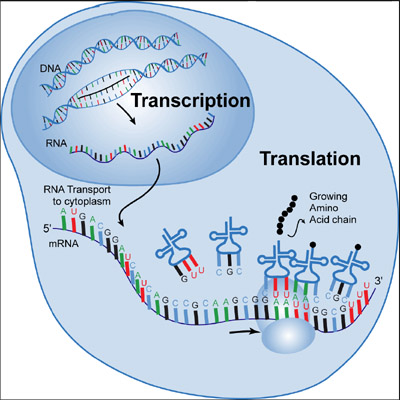

In [2]:
library("IRdisplay")
display_jpeg(file="central_dogma.jpeg", height = 600, width=600)  

## Project Description

- Perturbations in gene regulation during development can lead to cleft palate.
- Multiome experiment was done on embryonic days (E) 12.5, E13.5, E14.0, and E14.5
- Identified TF, SHOX2 and MEOX2 as important regulators of the palate development

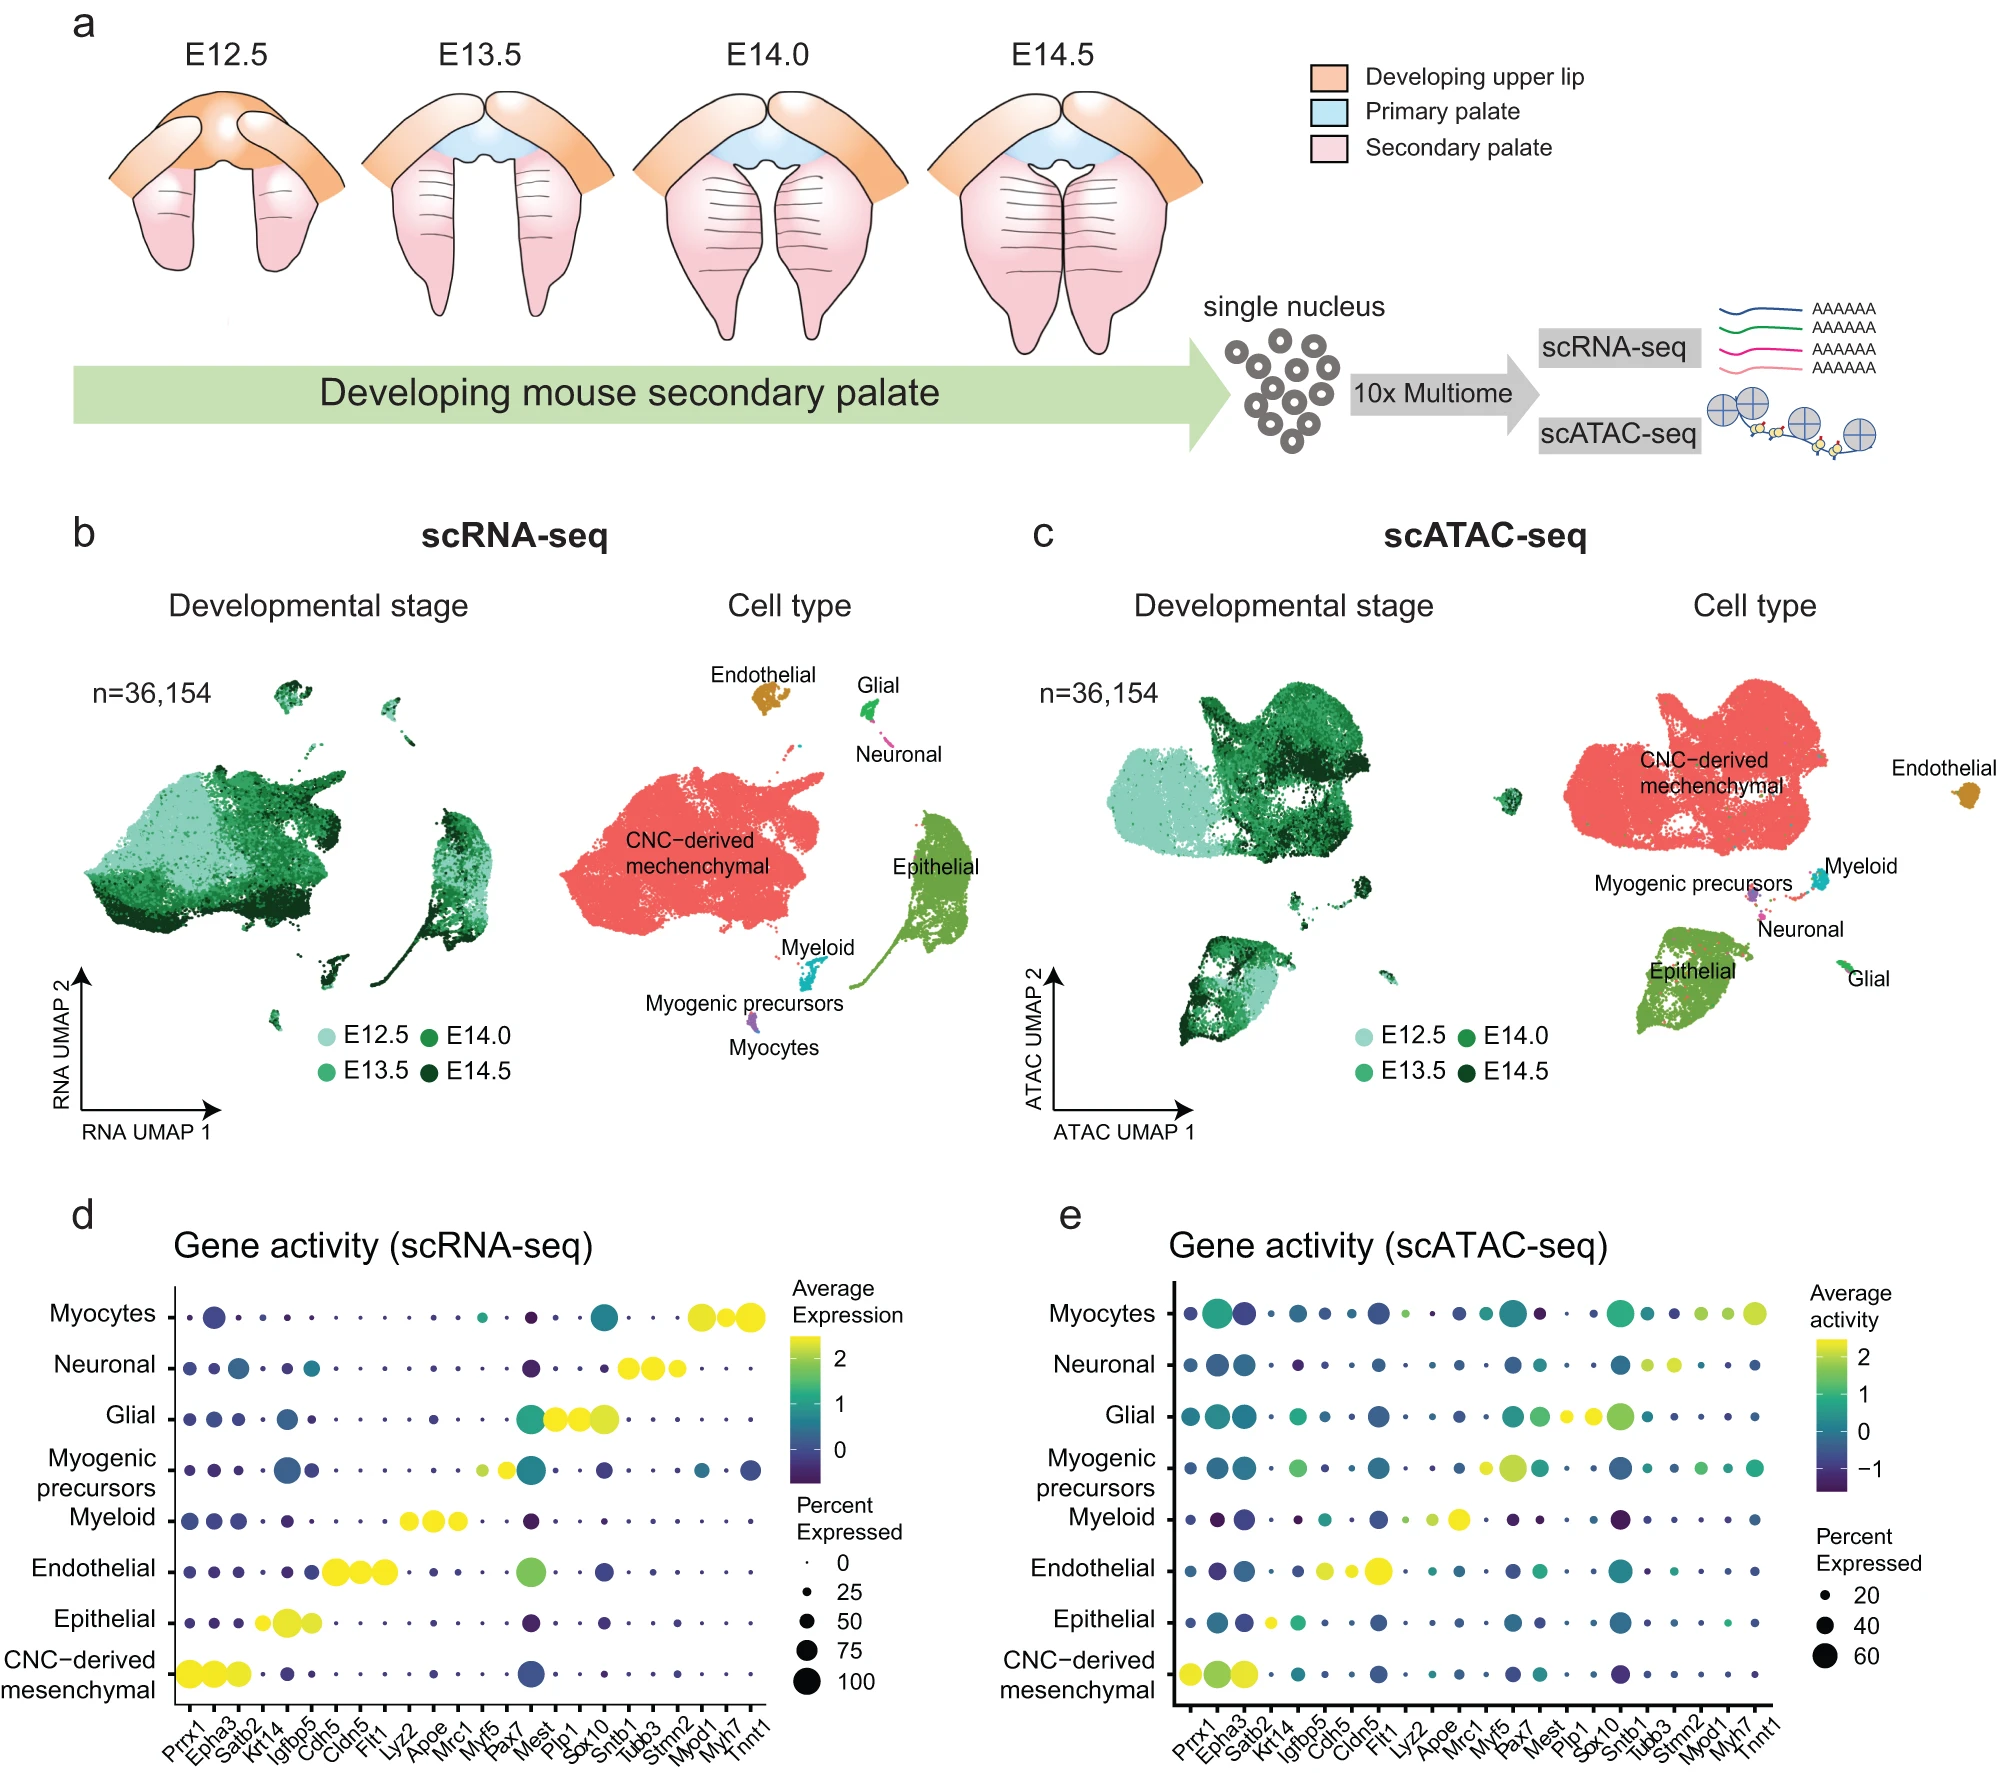

In [3]:
display_png(file="41467_2024_45199_Fig1_HTML.png", height = 1200, width= 1000)  

> Ref: [Nat Commun 15, 821 (2024)](https://doi.org/10.1038/s41467-024-45199-x). __a__ Schematic plot depicts the development of mouse secondary palate (pink) spanning embryonic day (E) 12.5 (n = 2), E13.5 (n = 3), E14.0 (n = 2), and E14.5 (n = 2). The isolated nuclei were subjected to 10x Chromium Multiome sequencing to profile scRNA-seq and scATAC-seq simultaneously within the same cells. __b, c__ Uniform manifold approximation and projection (UMAP) visualization of 36,154 cells based on RNA assay (b) or ATAC assay (c). Each dot represents one cell and is colored by the developmental stage (left) and annotated cell types (right). __d, e__ Dot plot illustrates marker gene expression (x axis) (d) and gene activity (e) (x axis) across cell types (y axis). Dot size is proportional to the percent of expressed cells. Colors indicate low (purple) to high (yellow) expression.

## Required files

- The Raw data (filtered_tf_bc_matrix.h5)
- The Metadata (singlecell.csv)
- The fragments file (fragments.tsv.gz)
- The fragments file index (fragments.tsv.gz.tbi)

# 1. Getting setup

The first thing we do is change to our desired our working directory, set the number of threads we would like to use, and load our **gene** and **genome** annotations. Depending on the configuration of your local environment, you may need to modify the number of threads used below in `addArchRThreads()`. By default ArchR uses **half** of the total number of threads available but you can adjust this manually as you see fit. 

First, we load the ArchR library.

In [ ]:
library(ArchR)
library(tidyverse)
library(HDF5Array)
library(hdf5r)
library(Seurat)

library(AnnotationHub)
library(cowplot)      # plotColData, plotRowData, plot_grid
library(ggforce)      # gather_set_data
library(ggplot2)
library(ggrepel)      # geom_text_repel
library(HDF5Array)    # saveHDF5SummarizedExperiment
library(igraph)       # cluster_walktrap
library(KernSmooth)   # smoothScatter
library(scales)
library(scran)
library(scDblFinder)
library(BSgenome.Mmusculus.UCSC.mm10)

In [ ]:
sessionInfo()

In [ ]:
#cbPalette <- paletteer_d(package = "ggthemes", palette="calc", n=12)
c30 <- c(
        "#7f0000", # maroon2
        "#006400", # darkgreen
        "#808000", # olive
        "#483d8b", # darkslateblue
        "#008b8b", # darkcyan
        "#cd853f", # peru
        "#4682b4", # steelblue
        "#00008b", # darkblue
        "#8fbc8f", # darkseagreen
        "#800080", # purple
        "#b03060", # maroon3
        "#ff0000", # red
        "#ff8c00", # darkorange
        "#cdcd00", # yellow3
        "#00ff00", # lime
        "#8a2be2", # blueviolet
        "#00ff7f", # springgreen
        "#dc143c", # crimson
        "#00ffff", # aqua
        "#0000ff", # blue
        "#f08080", # lightcoral
        "#adff2f", # greenyellow
        "#da70d6", # orchid
        "#ff00ff", # fuchsia
        "#1e90ff", # dodgerblue
        "#f0e68c", # khaki
        "#90ee90", # lightgreen
        "#ff1493", # deeppink
        "#696969", # dimgray
        "#dcdcdc"  # gainsboro
)
 
pie(rep(1,30), col = c30, radius = 1)

In [ ]:
# Choosing colours for samples
c_sample_col <- c30[c(1,3,23,19:28,30)]
# Choosing colour for samples
c_clust_col <- c30[c(1,2,3,4,5,6,7,8,9,11,12,14,19,22,24,25)]

### Setting seed
We also set known seed to facilitate replication of operations requiring randomization.

In [ ]:
set.seed(1)

### Setting thread

Next, we set the default number of threads for `ArchR` functions. This is something we will have to do during each new R session. `ArchR` recommend setting threads to **1/2** to **3/4** of the total available cores. The memory usage in `ArchR` will often scale with the number of threads used so allowing `ArchR` to use more threads will also lead to higher memory usage.

In [ ]:
addArchRThreads(threads = 1)

### Setting genome

Then, we set the genome to be used for gene and genome annotations. As above, this is something we will have to do during each new R session. Of course, this genome version must match the **genome version that was used for alignment**. For this data, we will use the `hg38` reference genome.

In [ ]:
addArchRGenome("mm10")

The precompiled version of the `hg38` genome in ArchR uses `BSgenome.Hsapiens.UCSC.hg38`, `TxDb.Hsapiens.UCSC.hg38.knownGene`, `org.Hs.eg.db`, and a blacklist that was merged using `ArchR::mergeGR()` from the `hg38 v2` blacklist regions and from mitochondrial regions that show high mappability to the `hg38` nuclear genome from Caleb Lareau and Jason Buenrostro. 

### 1.1 Creating Arrow Files

Now we will create our Arrow files which will take 10-15 minutes. For each sample, this step will:

1. Read accessible fragments from the provided input files.
2. Calculate quality control information for each cell (i.e. TSS enrichment scores and nucleosome info).
3. Filter cells based on quality control parameters.
4. Create a genome-wide TileMatrix using 500-bp bins.
5. Create a `GeneScoreMatrix` using the custom geneAnnotation that was defined when we called `addArchRGenome()`.

Before creating the Arrow files, we first need to read the valid barcode files using the function `getValidBarcodes()` 


In [ ]:
inputFiles <- c('data/GSE218576_B6E12-5-1_atac_fragments.tsv.gz',
                'data/GSE218576_B6E12-5-2_atac_fragments.tsv.gz',
                'data/GSE218576_B6E13-5-1_atac_fragments.tsv.gz',
                'data/GSE218576_B6E13-5-2_atac_fragments.tsv.gz',
                'data/GSE218576_B6E13-5-3_atac_fragments.tsv.gz',
                'data/GSE218576_B6E14-0-1_atac_fragments.tsv.gz',
                'data/GSE218576_B6E14-0-2_atac_fragments.tsv.gz',
                'data/GSE218576_B6E14-5-1_atac_fragments.tsv.gz',
                'data/GSE218576_B6E14-5-2_atac_fragments.tsv.gz')

In [ ]:
inputFiles

Note: 
TSS score = the depth of TSS (each 100bp window within 1000 bp each side) / the depth of end flanks (100bp each end).

In [ ]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles, # Path of the fragment files
  sampleNames = c('B6E12-5-1','B6E12-5-2', 'B6E13-5-1','B6E13-5-2', 'B6E13-5-3','B6E14-0-1', 'B6E14-0-2', 'B6E14-5-1', 'B6E14-5-2'), # Sample names
  minTSS = 4,      # Dont set this too high because you can always increase later. 
                      # The minimum numeric transcription start site (TSS) enrichment score required for a cell 
                      # to pass filtering for use in downstream analyses. Cells with a TSS enrichment score greater than or equal to filterTSS will be retained. 
                      # TSS enrichment score is a measurement of signal-to-background in ATAC-seq.
  minFrags = 1000, # minimum number of mapped ATAC-seq fragments required per cell to pass filtering for use in downstream analyses. 
                      #Cells containing greater than or equal to filterFrags total fragments wll be retained.
  #validBarcodes = validBarcodes, # List of valid Barcodes
  addTileMat = TRUE,  #A boolean value indicating whether to add a "Tile Matrix" to each ArrowFile. 
                      # A Tile Matrix is a counts matrix that, instead of using peaks, 
                      # uses a fixed-width sliding window of bins across the whole genome. 
                      # This matrix can be used in many downstream ArchR operations
  addGeneScoreMat = TRUE, #A boolean value indicating whether to add a Gene-Score Matrix to each ArrowFile. 
                         # A Gene-Score Matrix uses ATAC-seq signal proximal to the TSS to estimate gene activity.
 force = TRUE
)

In [ ]:
archr_multiome_proj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "multiome_lit_aggr",
  showLogo = FALSE,
  copyArrows = TRUE #This is recommened so that you maintain an unaltered copy for later usage.
)

In [ ]:
archr_multiome_proj 

## Inputing GEX

In [ ]:
seRNA <- import10xFeatureMatrix(
    input = c('data/GSE218576_B6E12-5-1_filtered_feature_bc_matrix.h5',
              'data/GSE218576_B6E12-5-2_filtered_feature_bc_matrix.h5',
              'data/GSE218576_B6E13-5-1_filtered_feature_bc_matrix.h5',
             'data/GSE218576_B6E13-5-2_filtered_feature_bc_matrix.h5',
             'data/GSE218576_B6E13-5-3_filtered_feature_bc_matrix.h5',
             'data/GSE218576_B6E14-0-1_filtered_feature_bc_matrix.h5',
             'data/GSE218576_B6E14-0-2_filtered_feature_bc_matrix.h5',
             'data/GSE218576_B6E14-5-1_filtered_feature_bc_matrix.h5',
             'data/GSE218576_B6E14-5-2_filtered_feature_bc_matrix.h5'),
    names = c('B6E12-5-1','B6E12-5-2', 'B6E13-5-1','B6E13-5-2', 'B6E13-5-3','B6E14-0-1', 'B6E14-0-2', 'B6E14-5-1', 'B6E14-5-2')
)

In [ ]:
seRNA

In [ ]:
seRNA <- scDblFinder(seRNA)
table(seRNA$scDblFinder.class)

## Remove doublets

In [ ]:
seRNA <- seRNA[,seRNA$scDblFinder.class %in% 'singlet']

In [ ]:
seRNA

In [ ]:
head(rowData(seRNA))

In [ ]:
colnames(colData(seRNA))

__Add single nuclei RNA-seq value__

## 1.2 Quality control per cell

Strict quality control (QC) of scATAC-seq data is essential to remove the contribution of low-quality cells. In `ArchR`, we consider three characteristics of data:

1. The number of unique nuclear fragments (i.e. not mapping to mitochondrial DNA).
2. The signal-to-background ratio. Low signal-to-background ratio is often attributed to dead or dying cells which have de-chromatinzed DNA which allows for random transposition genome-wide.
3. The fragment size distribution. Due to nucleosomal periodicity, we expect to see depletion of fragments that are the length of DNA wrapped around a nucleosome (approximately 147 bp).

> **Unique nuclear fragments**, is straightforward - cells with very few usable fragments will not provide enough data to make useful interpretations and should therefore be excluded.

> **Signal-to-background ratio**, is calculated as the **TSS enrichment score**. Traditional bulk ATAC-seq analysis has used this TSS enrichment score for determination of signal-to-background (for example, the [ENCODE project](https://www.encodeproject.org/atac-seq/)). The idea behind the TSS enrichment score metric is that ATAC-seq data is universally enriched at gene TSS regions compared to other genomic regions, due to large protein complexes that bind to promoters. By looking at per-basepair accessibility centered at these TSS regions, we see a local enrichment relative to flanking regions (1900-2000 bp distal in both directions). The ratio between the peak of this enrichment (centered at the TSS) relative to these flanking regions represents the TSS enrichment score.

Traditionally, the per-base-pair accessibility is computed for each bulk ATAC-seq sample and then this profile is used to determine the TSS enrichment score. Performing this operation on a per-cell basis in scATAC-seq is relatively slow and computationally expensive. To accurately approximate the TSS enrichment score per single cell, `ArchR` count the average accessibility within a 50-bp region centered at each single-base TSS position and divide this by the average accessibility of the TSS flanking positions (+/- 1900 – 2000 bp). This approximation was highly correlated (R > 0.99) with the original method and values were extremely close in magnitude.

> **Fragment size distribution**, is generally less important but always good to manually inspect. Because of the patterned way that DNA wraps around nucleosomes, we expect to see a nucleosomal periodicity in the distribution of fragment sizes in our data. These hills and valleys appear because fragments must span 0, 1, 2, etc. nucleosomes (Tn5 cannot cut DNA that is tightly wrapped around a nucleosome.

By default in ArchR, pass-filter cells are identified as those cells having a TSS enrichment score greater than 4 and more than 1000 unique nuclear fragments. It is important to note that the actual numeric value of the TSS enrichment score depends on the set of TSSs used. The default values in ArchR were designed for human data and it may be important to change the default thresholds when running createArrowFiles().

Creation of Arrow files created a folder in the current working directory called “QualityControl” which will contain 2 plots associated with each of our samples. The first plot shows the log10(unique nuclear fragments) vs TSS enrichment score and indicates the thresholds used with dotted lines. The second shows the fragment size distribution.


## 1.3 Inferring Doublets
After Arrow file creation, we can infer potential doublets (a single droplet containing multiple cells) that can confound downstream results. This is done using the `addDoubletScores()` function.

### How does doublet identification work in ArchR?

Single-cell data generated on essentially any platform is susceptible to the presence of doublets. A doublet refers to a single droplet that received a single barcoded bead and more than one nucleus. This causes the reads from more than one cell to appear as a single cell. For 10x, the percentage of total “cells” that are actually doublets is proportional to the number of cells loaded into the reaction. Even at the lower levels of doublets that result from standard kit use, more than 5% of the data may come from doublets and this exerts substantial effects on clustering. This issue becomes particularly problematic in the context of developmental/trajectory data because doublets look like a mixture between two cell types and this can be confounded with intermediate cell types or cell states.

To predict which “cells” are actually doublets, we synthesize in silico doublets from the data by mixing the reads from thousands of combinations of individual cells. We then project these synthetic doublets into the UMAP embedding and identify their nearest neighbor. By iterating this procedure thousands of times, we can identify “cells” in our data whose signal looks very similar to synthetic doublets.


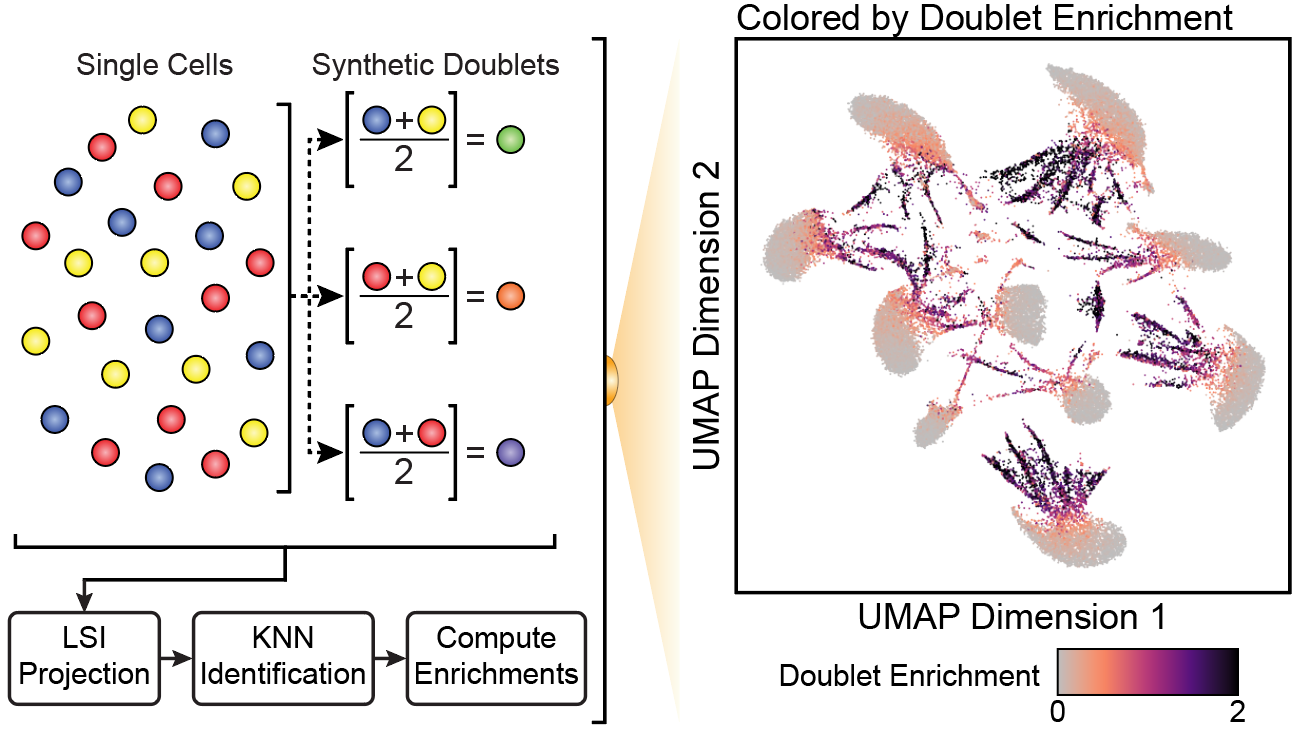

In [4]:
display_png(file="doubletRemoval.png", height = 800, width = 800)

In [ ]:
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
    knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search with doublet projection.
    UMAPParams = list(n_neighbors = 20),
    LSIMethod = 1,
    verbose = FALSE
)

In [ ]:
archr_multiome_proj

In the above output, ArchR reports the R2 value for the UMAP projection for each Arrow file. If these R2 values are much lower (i.e. less than 0.9), this often indicates that the cells within the Arrow file have very little heterogeneity. This makes the accuracy of doublet calling worse because the majority of doublets would be “homotypic” - or a single droplet with two very similar cells. In these cases, we recommend skipping doublet prediction. Alternatively, you can try setting knnMethod = "LSI" and force = TRUE to perform projection in the LSI subspace; however, you should manually assess the results and make sure this is performing as you would expect.

Adding doublet scores will create plots in the “QualityControl” directory. There are 3 plots associated with each of your samples in this folder:

1. **Doublet Enrichments** - These represent the enrichment of simulated doublets nearby each single cell compared to the expected if we assume a uniform distribution.
2. **Doublet Scores** - These represent the significance (-log10(binomial adjusted p-value)) of simulated doublets nearby each single cell compared to the expected if we assume a uniform distribution. We have found this value to be less consistent than the doublet enrichments and therefore use doublet enrichments for doublet identification.
3. **Doublet Density** - This represents the density of the simulated doublet projections. This allows you to visualize where the synthetic doublets were located after projection into your 2-dimensional embedding.

## 1.4 Creating an ArchRProject
An ArchRProject allows us to group multiple Arrow files together into a single project. This ArchRProject is small and is stored in memory. By interacting with the ArchRProject we can rapidly push and pull data from the Arrow files. As such, it forms the basis of nearly all ArchR functions and analytical workflows. Moreover, ArchRProject objects can be saved and re-loaded at a later date, providing continuity of analyses and facilitating sharing of analytical projects across collaborators. 

We can see from the above that our ArchRProject has been initialized with a few important attributes:

1. The specified outputDirectory.
2. The sampleNames of each sample which were obtained from the Arrow files.
3. A matrix called sampleColData which contains data associated with each sample.
4. A matrix called cellColData which contains data associated with each cell. Because we already computed doublet enrichment scores using addDoubletScores(), which added those values to each cell in the Arrow files, we can see columns corresponding to the “DoubletEnrichment” and “DoubletScore” in the cellColData matrix.
5. The total number of cells in our project which represents all samples after doublet identification and removal.
6. The median TSS enrichment score and the median number of fragments across all cells and all samples.

### Calculating Gene Scores in ArchR

For each chromosome, `ArchR` creates a tile matrix using a user-defined tile size that is not pre-computed (default is 500 bp), overlaps these tiles with the user-defined gene window (default is 100 kb on either side of the gene), and then computes the distance from each tile (start or end) to the gene body (with optional extensions upstream or downstream) or gene start. We have found that the best predictor of gene expression is the local accessibility of the gene region which includes the promoter and gene body. As mentioned above, to properly account for distal accessibility for a given gene, `ArchR` identifies the subset of tiles that are within the gene window and do not cross another gene region. This filtering allows for inclusion of distal regulatory elements that could improve the accuracy of predicting gene expression values but excludes regulatory elements more likely to be associated with another gene (for ex. the promoter of a nearby gene). The distance from each tile to the gene is then converted to a distance weight using a user-defined accessibility model (default is $e^{-abs(distance)/5000} + e^{-1})$. When the gene body is included in the gene region (where the distance-based weight is the maximum weight possible), we found that extremely large genes can bias the overall gene scores. In these cases, the total gene scores can vary substantially due to the inclusion of insertions in both introns and exons. To help adjust for these large differences in gene size, `ArchR` applies a separate weight for the inverse of the gene size ($\frac{1}{gene size}$) and scales this inverse weight linearly from 1 to a user-defined hard maximum (default of 5). Smaller genes thus receive larger relative weights, partially normalizing this length effect. The corresponding distance and gene size weights are then multiplied by the number of Tn5 insertions within each tile and summed across all tiles within the gene window, while still accounting for nearby gene regions as described above. This summed accessibility is a “gene score” and is depth normalized across all genes to a user-defined constant (default of 10,000). Computed gene scores are then stored in the corresponding Arrow file for downstream analyses.

To illustrate what the default ArchR gene score model looks like, we provide this toy example showing the weighting applied across the entire gene region:


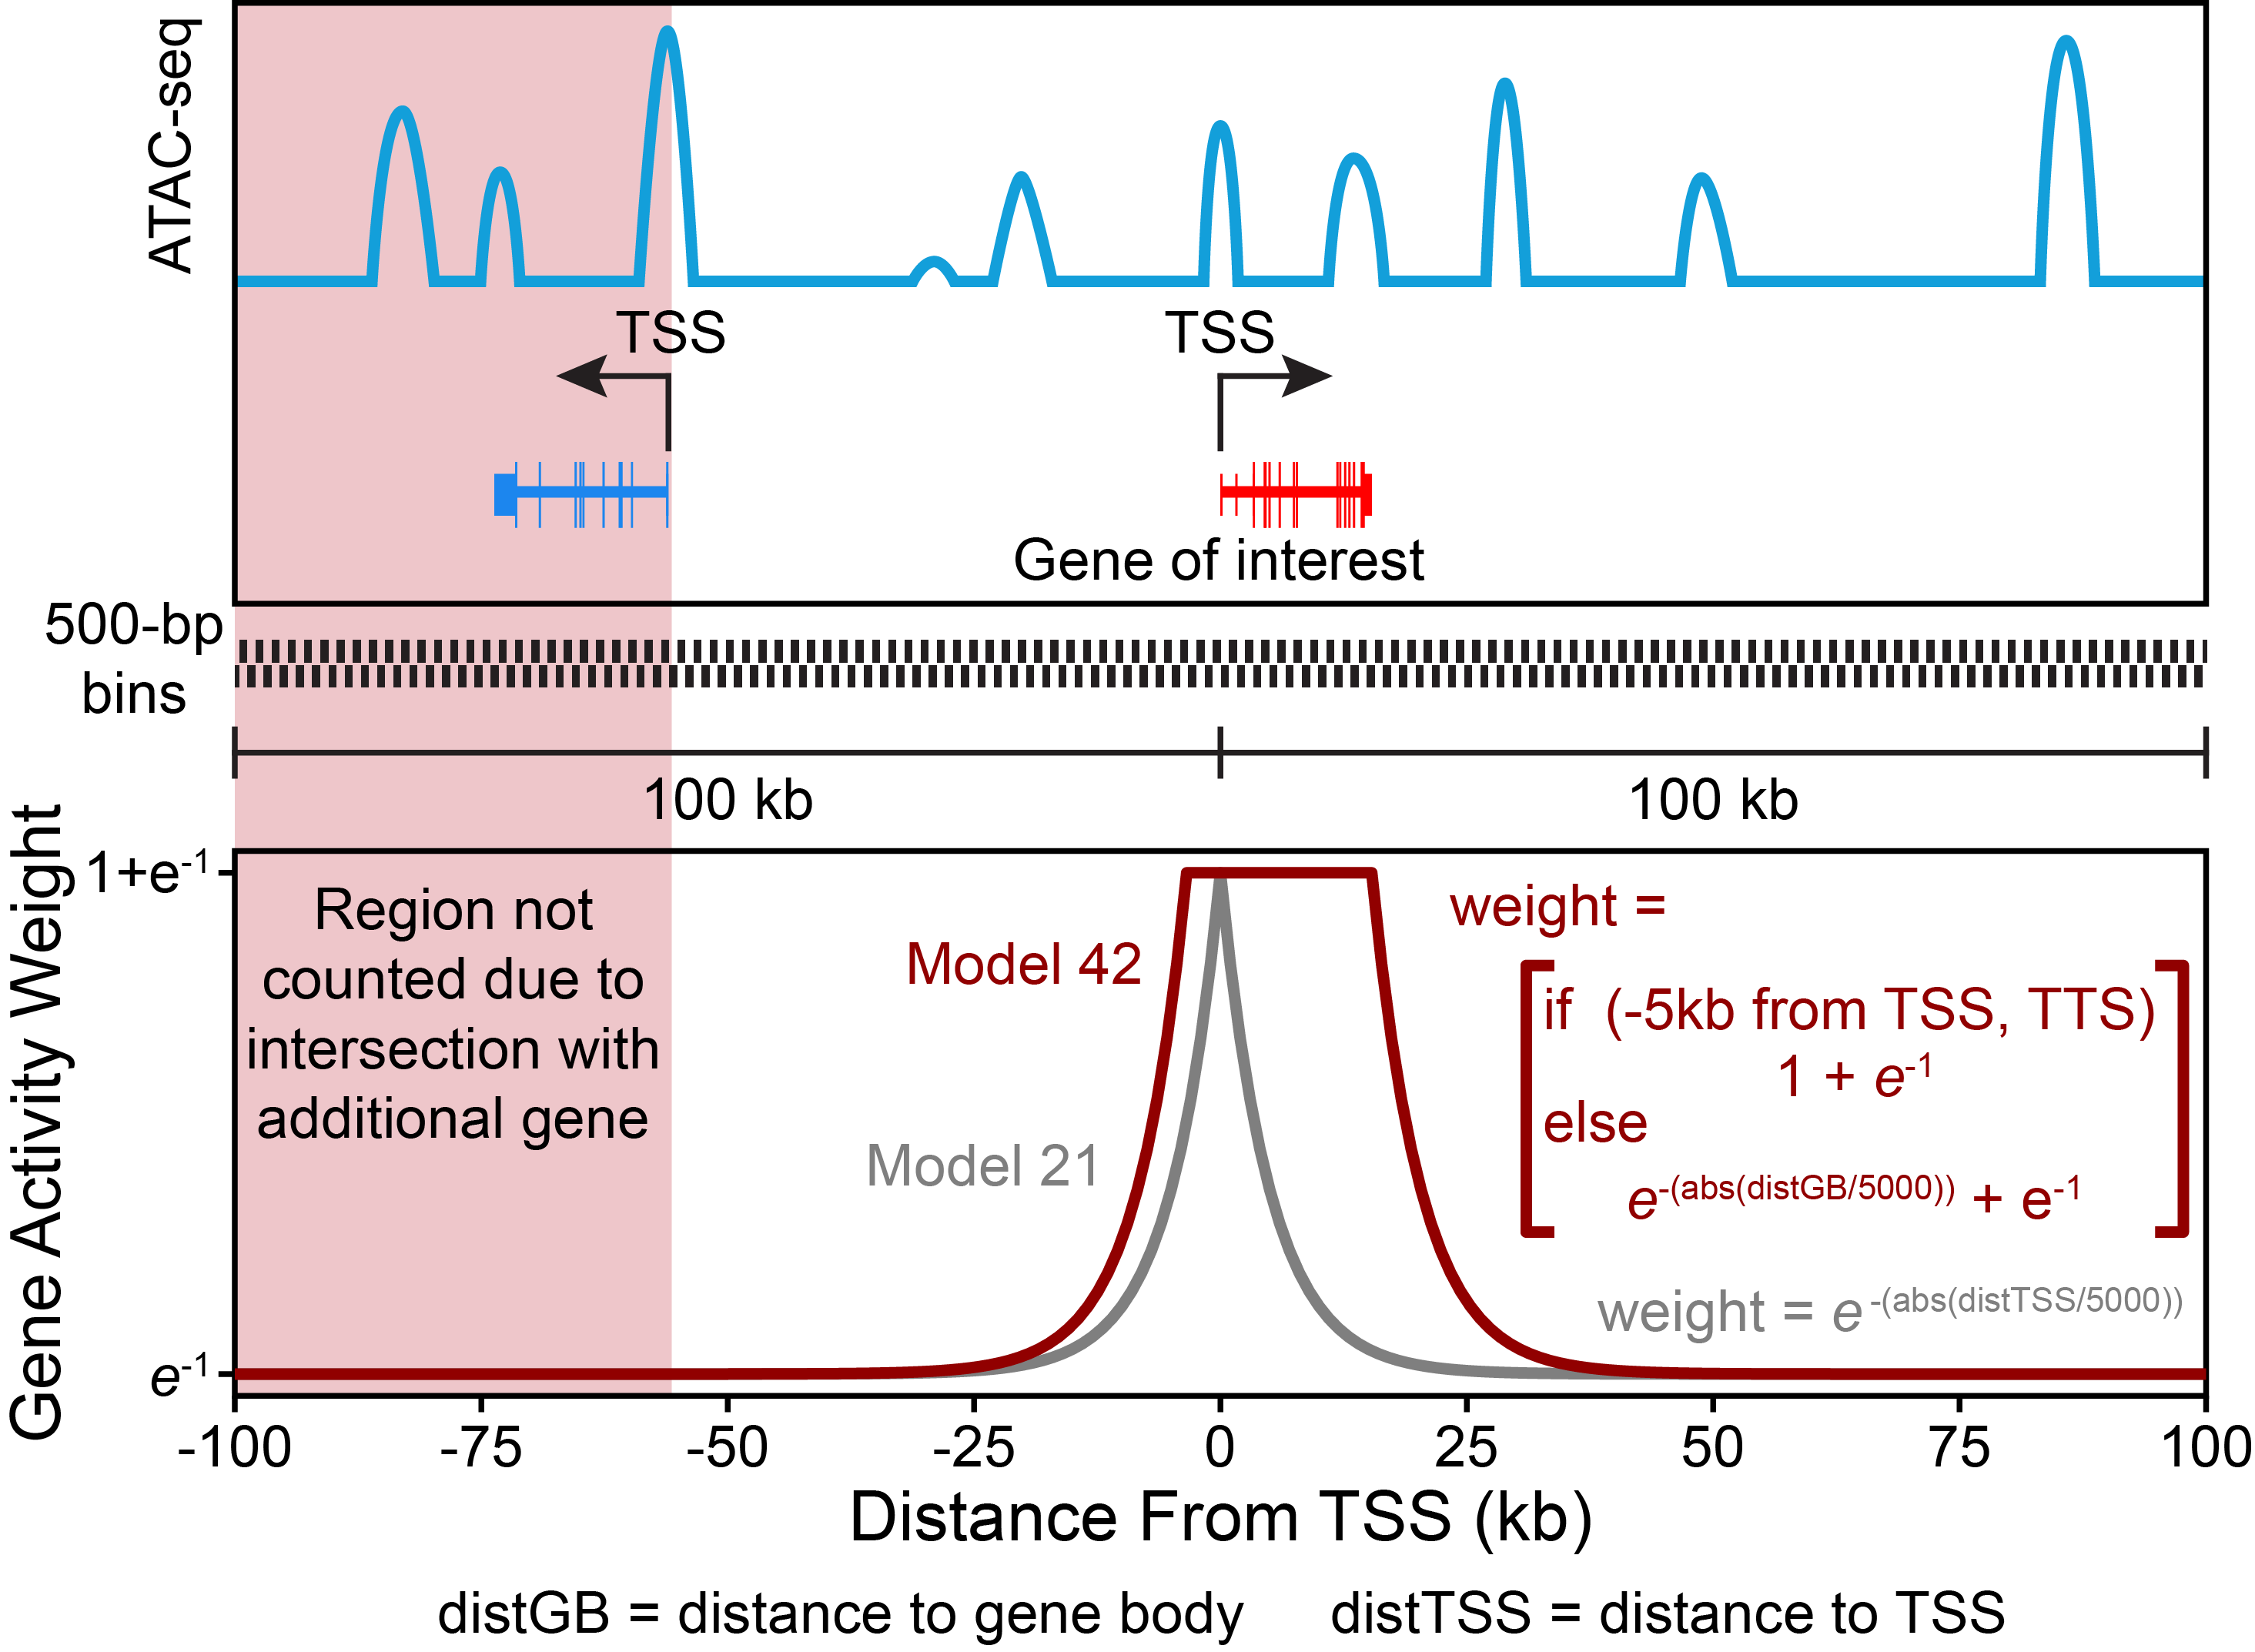

In [5]:
display_png(file="GeneActivityScore_Schematic.png", height = 800, width = 800) 

**Now we can filter putative doublets based on the previously determined doublet scores using the filterDoublets() function. This doesn’t physically remove data from the Arrow files but rather tells the ArchRProject to ignore these cells for downstream analysis.**

In [ ]:
archr_multiome_proj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "multiome_aggr",
  showLogo = FALSE,
  copyArrows = TRUE #This is recommened so that you maintain an unaltered copy for later usage.
)

In [ ]:
archr_multiome_proj <- filterDoublets(ArchRProj = archr_multiome_proj)

Cells passing the QC in three samples

In [ ]:
table(archr_multiome_proj$Sample)

In [ ]:
# You can also filter using the following command
archr_multiome_proj <- archr_multiome_proj[archr_multiome_proj$TSSEnrichment > 6 & 
                                               archr_multiome_proj$nFrags > 2500]

In [ ]:
p1 <- plotGroups(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "ridges"
   )

p2 <- plotGroups(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "ReadsInTSS",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

p3 <- plotGroups(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "ReadsInPromoter",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

p4 <- plotGroups(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "ReadsInBlacklist",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
p5 <- plotGroups(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "PromoterRatio",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

In [ ]:
options(repr.plot.width=16, repr.plot.height=6)
ggAlignPlots(p1, p2, p3, p4, p5, type = "h")

In [ ]:
#Add scRNA
archr_multiome_proj <- addGeneExpressionMatrix(input = archr_multiome_proj, seRNA = seRNA_combined, force = TRUE)

## Filter cells that matches the RNA-seq

In [ ]:
archr_multiome_proj <- archr_multiome_proj[!is.na(archr_multiome_proj$Gex_nUMI)]

In [ ]:
archr_multiome_proj

## Additional filtering with RNA-seq modality

Histogram for Library size

In [ ]:
options(repr.plot.width=8, repr.plot.height=6)
# Print library size summary
summary(getCellColData(archr_multiome_proj)$Gex_nUMI)

# Plot histogram
ggplot(as.data.frame(getCellColData(archr_multiome_proj)), aes(x = Gex_nUMI, fill = Sample)) + 
    geom_histogram(color = "white", alpha = 0.6, size = 0.3, bins = 50) +
    scale_x_continuous(labels = unit_format(unit = "K", scale = 1e-3)) +
    scale_fill_manual(values = c_sample_col) + 
    guides(fill = guide_legend(override.aes = list(alpha = 1))) +
    theme_classic(base_size = 20) +
    labs(x = "Library size", y = "Number of cells", title = "Histogram of library size")

Histogram of detected genes

In [ ]:
# Print detected genes summary
summary(getCellColData(archr_multiome_proj)$Gex_nGenes)

# Plot histogram
ggplot(as.data.frame(getCellColData(archr_multiome_proj)), aes(x = Gex_nGenes, fill = Sample)) +
    geom_histogram(color = "white", alpha = 0.6, size = 0.3, bins = 50) +
    scale_x_continuous(labels = unit_format(unit = "K", scale = 1e-3)) +
    scale_fill_manual(values = c_sample_col) + 
    guides(fill = guide_legend(override.aes = list(alpha = 1))) +
    theme_classic(base_size = 20) +
    labs(x = "Number of detected genes", y = "Number of cells", title = "Histogram of detected genes")

In [ ]:
# Print mitochondrial proportion summary
summary(getCellColData(archr_multiome_proj)$Gex_MitoRatio)

#print("Number of cells with 0% mitochondrial content:")
#data.frame(Sample = colData(cdSc)$Sample, ZeroMito = colData(cdSc)$subsets_Mt_percent == 0) %>%
#    count(Sample, ZeroMito, name = "Count") %>% group_by(Sample) %>% 
#    mutate(Percentage = round(prop.table(Count)*100, 2))

# Plot histogram
ggplot(as.data.frame(getCellColData(archr_multiome_proj)), aes(x = Gex_MitoRatio, fill = Sample)) +
    geom_histogram(color = "white", alpha = 0.6, size = 0.3, bins = 50) +
    scale_fill_manual(values = c_sample_col) + 
    guides(fill = guide_legend(override.aes = list(alpha = 1))) +
    theme_classic(base_size = 20) +
    labs(x = "Mitochondrial proportion", y = "Number of cells", 
         title = "Histogram of Mitochondrial proportion")

In [ ]:
log10_breaks <- trans_breaks("log10", function(x) 10^x)
log10_labels <- trans_format("log10", math_format(10^.x))

In [ ]:
# Set a MAD of 3
# Set minimum library size cutoff at 500 if the MAD cutoff is lower than 500


In [ ]:
# Change this setting to adjust and show different threshold
mad1 <- 3
libsize.drop <- isOutlier(getCellColData(archr_multiome_proj)$Gex_nUMI, nmads = mad1, type = "lower", log = TRUE)
cut_off_reads <- attr(libsize.drop, "thresholds")["lower"]
round(cut_off_reads, 2)

# Set minimum library size cutoff at 500 if the MAD cutoff is lower than 500
cut_off_reads <- ifelse(cut_off_reads < 500, 500, cut_off_reads)
round(cut_off_reads, 2)

libsize.drop <- getCellColData(archr_multiome_proj)$Gex_nUMI < cut_off_reads

as.data.frame(getCellColData(archr_multiome_proj)) %>%
    ggplot(aes(x = Gex_nUMI, fill = factor(Sample))) +
    geom_density(color = NA, alpha = 0.5) + facet_wrap(~ Sample) +
    geom_vline(xintercept = cut_off_reads, colour = "red", linetype = "longdash") +
    annotate("text", x = cut_off_reads, y = Inf, label = round(cut_off_reads, 2), 
             vjust = 2, hjust = -0.2, size = 5) +
    theme_classic(base_size = 20) + scale_fill_manual(values = c_sample_col) +
    scale_x_log10(breaks = log10_breaks, labels = log10_labels) +
    theme(legend.position = "none") +
    labs(x = "Library Size", y = "density", title = "Total count", fill = "Sample", 
         subtitle = paste(sum(libsize.drop), "cell(s) to the left of cutoff have too low UMI count"))

as.data.frame(getCellColData(archr_multiome_proj)) %>% cbind(., libsize.drop) %>%
    rename(LowCount = libsize.drop) %>%
    ggplot(aes(x = factor(Sample), y = Gex_nUMI)) + geom_violin(size = 1) +
    geom_jitter(aes(color = LowCount), alpha = 0.3, size = 0.5, 
                position = position_jitter(height = 0, width = 0.15, seed = 123)) +
    theme_classic(base_size = 20) + scale_color_manual(values = c("black", "red")) +
    scale_y_log10(breaks = log10_breaks, labels = log10_labels) +
    guides(color = guide_legend(override.aes = list(size = 4, alpha = 1))) +
    labs(x = "Sample", y = "Library Size", title = "Total count", fill = "Sample", 
         subtitle = paste(sum(libsize.drop), "cell(s) coloured in red have too low UMI count"))

In [ ]:
# Change this setting to adjust and show different threshold
mad2 <- 3
feature.drop <- isOutlier(getCellColData(archr_multiome_proj)$Gex_nGenes, nmads = mad2, type = "lower", log = TRUE)
cut_off_genes <- attr(feature.drop, "thresholds")["lower"]
round(cut_off_genes, 2)

# Set minimum detected genes cutoff at 250 if the MAD cutoff is lower than 250
cut_off_genes <- ifelse(cut_off_genes < 250, 250, cut_off_genes)
round(cut_off_genes,2)

feature.drop <- getCellColData(archr_multiome_proj)$Gex_nGenes < cut_off_genes

as.data.frame(getCellColData(archr_multiome_proj)) %>%
    ggplot(aes(x = Gex_nGenes, fill = factor(Sample))) + 
    geom_density(color = NA, alpha = 0.5) + facet_wrap(~ Sample) +
    geom_vline(xintercept = cut_off_genes, colour = "red", linetype = "longdash") +
    annotate("text", x = cut_off_genes, y = Inf, label = round(cut_off_genes, 2), 
             vjust = 2, hjust = -0.2, size = 5) +
    theme_classic(base_size = 20) + scale_fill_manual(values = c_sample_col) +
    scale_x_log10(breaks = log10_breaks, labels = log10_labels) +
    theme(legend.position = "none") +
    labs(x = "Number of detected genes", y = "density", title = "Total detected genes", fill = "Sample", 
         subtitle = paste(sum(feature.drop), "cell(s) to the left of cutoff have too few detected genes"))

as.data.frame(getCellColData(archr_multiome_proj)) %>% cbind(., feature.drop) %>%
    rename(LowDetected = feature.drop) %>%
    ggplot(aes(x = factor(Sample), y = Gex_nGenes)) + geom_violin(size = 1) +
    geom_jitter(aes(color = LowDetected), alpha = 0.3, size = 0.5, 
                position = position_jitter(height = 0, width = 0.15, seed = 123)) +
    theme_classic(base_size = 20) + scale_color_manual(values = c("black", "red")) + 
    guides(color = guide_legend(override.aes = list(size = 4, alpha = 1))) +
    labs(x = "Sample", y = "Number of detected genes", title = "Total detected genes", fill = "Sample", 
         subtitle = paste(sum(feature.drop), "cell(s) coloured in red have too few detected genes"))

In [ ]:
# Change this setting to adjust and show different threshold
mad3 <- 3
mito.drop <- isOutlier(getCellColData(archr_multiome_proj)$Gex_MitoRatio, nmads = mad3, type = "higher")
cut_off_MT <- attr(mito.drop, "thresholds")["higher"]
round(cut_off_MT, 2)

# Set minimum cutoff at 10% if the MAD cutoff is lower than 10%
cut_off_MT <- ifelse(cut_off_MT < 5, 5, cut_off_MT)
# Set maximum cutoff at 15% if the MAD cutoff is higher than 15%
cut_off_MT <- ifelse(cut_off_MT > 15, 15, cut_off_MT)
round(cut_off_MT, 2)

mito.drop <- getCellColData(archr_multiome_proj)$Gex_MitoRatio > cut_off_MT

p <- as.data.frame(getCellColData(archr_multiome_proj)) %>% 
    ggplot(aes(x = Gex_MitoRatio, fill = factor(Sample))) + 
    geom_density(color = NA, alpha = 0.5) + facet_wrap(~ Sample) +
    geom_vline(xintercept = cut_off_MT, colour = "red", linetype = "longdash") +
    annotate("text", x = cut_off_MT, y = Inf, label = round(cut_off_MT, 2), 
             vjust = 2, hjust = -0.2, size = 5) +
    theme_classic(base_size = 20) + scale_fill_manual(values = c_sample_col) +
    theme(legend.position = "none") +
    labs(x = "Mitochondrial proportion", y = "density", title = "Mitochondrial proportion", fill = "Sample", 
         subtitle = paste(sum(mito.drop), "cell(s) to the right of cutoff have too high mitochondrial proportion"))

# Visual zoom to between 0 - 50%
if(max(getCellColData(archr_multiome_proj)$Gex_MitoRatio) > 50) {
    p <- p + coord_cartesian(xlim = c(0, 50))
}

p

## Show summary

In [ ]:
print(paste("Cells removed if:"))
print(paste("Read count below library size cutoff:", round(cut_off_reads, 4)))
print(paste("Number of genes expressed below feature cutoff:", round(cut_off_genes, 4)))
print(paste("MT percent above mito cutoff:", round(cut_off_MT, 4)))

In [ ]:
# Discard summary
discard <- libsize.drop | feature.drop | mito.drop 
archr_multiome_proj$discard = discard

venn.df <- data.frame(Sample = archr_multiome_proj$Sample, LibSize = libsize.drop, FeaturesExp = feature.drop, 
                      MitoProp = mito.drop, Total = discard)

print(paste("Total number of cells removed:"))
DataFrame(Cells = colSums(venn.df[,2:5]))

In [ ]:
limma::vennDiagram(venn.df[,2:4], cex = c(1.5,1.2,1.0))

## Filter poor-quality cells

A new object is created with the filtered dataset.

In [ ]:
archr_multiome_proj <- archr_multiome_proj[!discard]
archr_multiome_proj

### Saving project

In [ ]:
archr_multiome_proj <- saveArchRProject(ArchRProj = archr_multiome_proj)

In [ ]:
paste0("Memory Size = ", round(object.size(archr_multiome_proj) / 10^6, 3), " MB")

In [ ]:
getAvailableMatrices(archr_multiome_proj)

# 2 Dimensionality Reduction and Clustering

ArchR implements a **few different** LSI implementations and we have benchmarked many of these methods across multiple different test data sets. ArchR’s default LSI implementation is related to the method introduced by Timothy Stuart in [Signac](https://satijalab.org/signac/), which uses a term frequency that has been depth normalized to a constant (10,000) followed by normalization with the inverse document frequency and then log-transforming the resultant matrix (aka log(TF-IDF)).

One of the key inputs to LSI dimensionality reduction is the starting matrix. Thus far, the two main strategies in scATAC-seq have been to 
1. Use peak regions: However, using peak regions for LSI is inherently challenging because we do not have clusters or cluster-specific peaks prior to dimensionality reduction. Moreover, calling peaks on aggregated cells prior to clustering obscures cell type-specific peaks. Moreover, any union peak set will change when new samples are added to an experiment, making this strategy less stable.

2. Genome-wide tiles: mitigates these issues by using a consistent and unbiased feature set (genome-wide tiles). However, a genome-wide tile matrix of all cells by all regions can become prohibitively large. For this reason, most implementations use tiles that are greater than or equal to 5 kilobases in size. This drastically reduces the resolution of the approach because most accessible regions are only a few hundred basepairs long.

Because of the way that Arrow files are designed, ArchR is able to perform LSI very rapidly using genome-wide 500-bp tiles. This solves the problem of resolution and allows for the identification of clusters prior to calling peaks. The challenge is that 500-bp bins generate around 6 million features to be included in the cell by tile matrix. While ArchR is able to read this large amount of data into R by chunking the relevant matrices, we have also implemented an “estimated LSI” approach that performs the initial dimensionality reduction on a subset of the total cells. This estimated LSI approach has two main utilities - (i) it speeds up dimensionality reduction and (ii) as you decrease the number of cells used in the intial dimensionality reduction, this decreases the granularity of the data. This reduction in granularity can be used to your advantage to reduce batch effects in your data. However, it can also obscure true biology so estimated LSI approaches should be used under close manual supervision.

## 2.1 Iterative Latent Semantic Indexing (LSI)

In scRNA-seq identifying _variable genes_ is a common way to compute dimensionality reduction (such as PCA). This is done because these highly variable genes are more likely to be biologically important and this reduces experimental noise. In scATAC-seq the data is **binary** and thus you cannot identify variable peaks for dimensionality reduction. Rather than identifying the most variable peaks, we have tried using the most accessible features as input to LSI; however, the results when running multiple samples have shown high degrees of noise and low reproducibility. To remedy this we introduced the **iterative LSI** approach ([Satpathy*, Granja* et al. Nature Biotechnology 2019](https://www.ncbi.nlm.nih.gov/pubmed/31375813) and [Granja*, Klemm* and McGinnis* et al. Nature Biotechnology 2019](https://www.ncbi.nlm.nih.gov/pubmed/31792411)). This approach computes an inital LSI transformation on the most accessible tiles and identifies lower resolution clusters that are not batch confounded. For example, when performed on peripheral blood mononuclear cells, this will identify clusters corresponding to the major cell types (T cells, B cells, and monocytes). Then `ArchR` computes the average accessibility for each of these clusters across all features. ArchR then identifies the most variable peaks across these clusters and uses these features for LSI again. In this **second iteration**, the most variable peaks are more similar to the variable genes used in scRNA-seq LSI implementations. The user can set how many iterations of LSI should be performed. We have found this approach to minimize observed batch effects and allow dimensionality reduction operations on a more reasonably sized feature matrix.


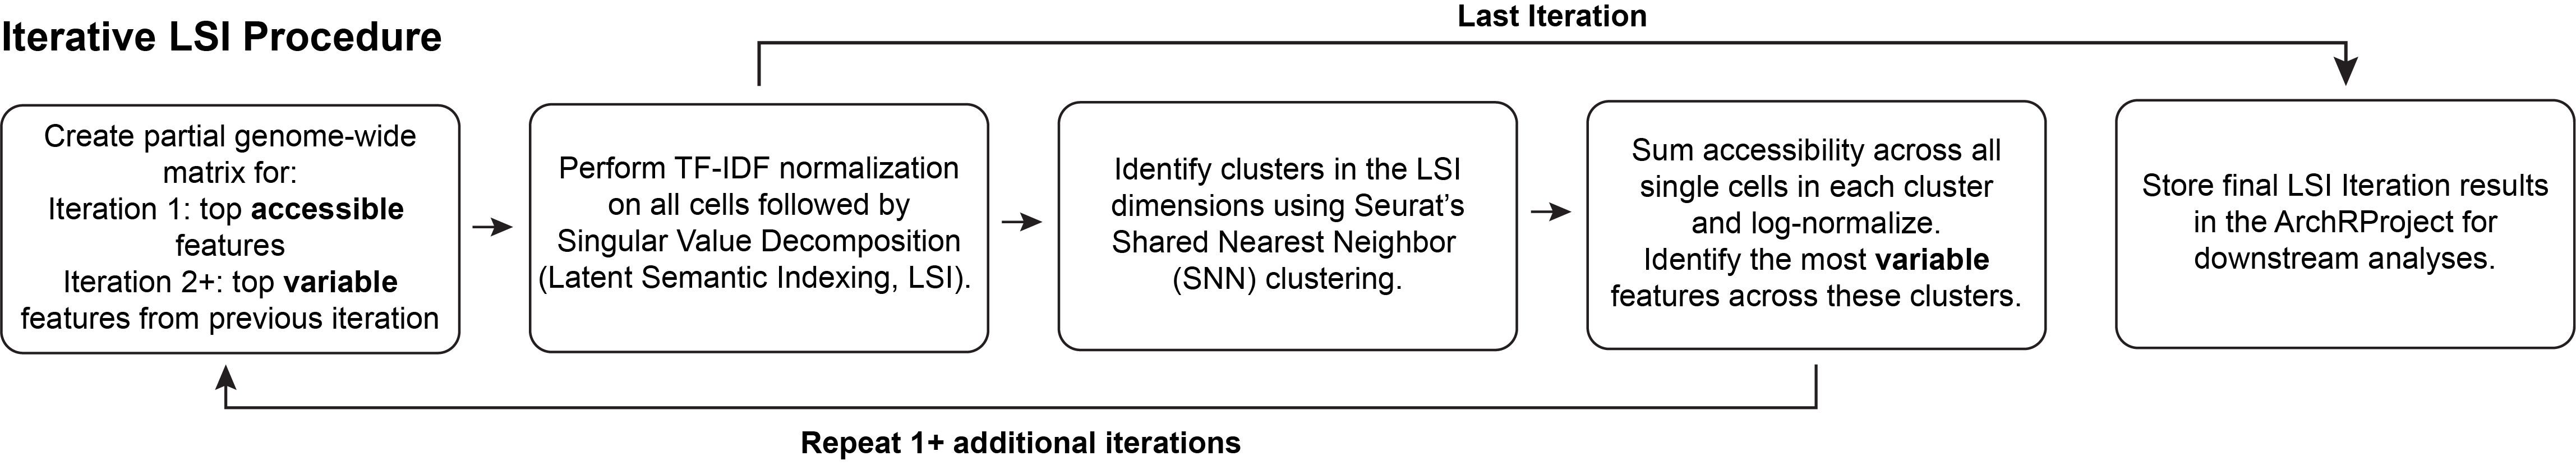

In [6]:
display_png(file="IterativeLSI_Flowchart.png", height = 1300, width = 1300) 

In [ ]:
#LSI-ATAC
archr_multiome_proj <- addIterativeLSI(
    ArchRProj = archr_multiome_proj, 
    clusterParams = list(
      resolution = 0.2, 
      sampleCells = 10000,
      n.start = 10
    ),
    saveIterations = FALSE,
    useMatrix = "TileMatrix", 
    depthCol = "nFrags",
    name = "LSI_ATAC"
)


### Add LSI to RNA

In [ ]:
#LSI-RNA
archr_multiome_proj <- addIterativeLSI(
    ArchRProj = archr_multiome_proj, 
    clusterParams = list(
      resolution = 0.2, 
      sampleCells = 10000,
      n.start = 10
    ),
    saveIterations = FALSE,
    useMatrix = "GeneExpressionMatrix", 
    depthCol = "Gex_nUMI",
    varFeatures = 2500,
    firstSelection = "variable",
    binarize = FALSE,
    name = "LSI_RNA"
)

## Combined dimensions

In [ ]:
#Combined Dims
archr_multiome_proj <- addCombinedDims(archr_multiome_proj, 
                                         reducedDims = c("LSI_ATAC", "LSI_RNA"), name =  "LSI_Combined")

In [ ]:
colnames(archr_multiome_proj@reducedDims$LSI_Combined$matRD) <- paste0('LSI',1:length(colnames(getReducedDims(archr_multiome_proj,'LSI_Combined'))))

## UMAP on snATAC-seq

In [ ]:
#UMAPs
archr_multiome_proj <- addUMAP(archr_multiome_proj, 
                                 reducedDims = "LSI_ATAC", name = "UMAP_ATAC", 
                                 minDist = 0.8, force = TRUE)

## UMAP on snRNA-seq

In [ ]:
#UMAPs
archr_multiome_proj <- addUMAP(archr_multiome_proj,
                                 reducedDims = "LSI_RNA", 
                                 name = "UMAP_RNA", minDist = 0.8, force = TRUE)

## Umap on combined dimensions

In [ ]:
archr_multiome_proj <- addUMAP(archr_multiome_proj, 
                                 reducedDims = "LSI_Combined", 
                                 name = "UMAP_Combined", minDist = 0.8, force = TRUE)

**If we see downstream that you have subtle batch effects, another option is to add more LSI iterations and to start from a lower intial clustering resolution. Additionally the number of variable features can be lowered to increase focus on the more variable features.**

## 2.2 Add cluster

In `ArchR`, clustering is performed using the `addClusters()` function which permits additional clustering parameters to be passed to the `Seurat::FindClusters()` function via .... In our hands, clustering using `Seurat::FindClusters()` is deterministic, meaning that the exact same input will always result in the exact same output.

## Cluster on combined dimension

In [ ]:
archr_multiome_proj <- addClusters(archr_multiome_proj, reducedDims = "LSI_Combined", 
                                     name = "Clusters", resolution = 0.4, force = TRUE)

## Cluster on ATAC dimension

In [ ]:
archr_multiome_proj <- addClusters(archr_multiome_proj, reducedDims = "LSI_ATAC", 
                                     name = "Clusters_ATAC", resolution = 0.4, force = TRUE)

## Cluster on RNA dimension

In [ ]:
archr_multiome_proj <- addClusters(archr_multiome_proj, reducedDims = "LSI_RNA", 
                                     name = "Clusters_RNA", resolution = 0.4, force = TRUE)

In [ ]:
df <- data.frame(Combined = archr_multiome_proj$Clusters, 
                 ATAC = archr_multiome_proj$Clusters_ATAC,
                 RNA = archr_multiome_proj$Clusters_RNA)

In [ ]:
head(df)

In [ ]:
table(df[,c('Combined','ATAC')])

In [ ]:
table(df[,c('Combined','RNA')])

In [ ]:
table(df[,c('ATAC','RNA')])

In [ ]:
table_samples_by_clusters <- as_tibble(df) %>%
  group_by(Combined, ATAC) %>%
  summarize(count = n()) %>%
  spread(ATAC, count, fill = 0) %>%
  ungroup() %>%
  mutate(total_cell_count = rowSums(.[c(2:ncol(.))])) %>%
  dplyr::select(c('Combined', 'total_cell_count', everything()))

In [ ]:
p1 <- table_samples_by_clusters %>%
  dplyr::select(-c('total_cell_count')) %>%
  reshape2::melt(id.vars = 'Combined') %>%
  mutate(Combined = factor(Combined)) %>%
  ggplot(aes(Combined, value, fill = variable)) +
  geom_bar(position = 'stack', stat = 'identity') +
  scale_fill_manual(name = 'ATAC', values = c_clust_col) +
  scale_y_continuous(name = 'Number of cells', labels = scales::comma, expand = c(0.01, 0)) +
  theme_bw() +
  theme(
    legend.position = 'left',
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
  )
p1

In [ ]:
p1 <- table_samples_by_clusters %>%
  dplyr::select(-c('total_cell_count')) %>%
  reshape2::melt(id.vars = 'Combined') %>%
  mutate(Combined = factor(Combined)) %>%
  ggplot(aes(Combined, value, fill = variable)) +
  geom_bar(position = 'fill', stat = 'identity', show.legend = TRUE) +
  scale_fill_manual(name = 'ATAC', values = c_clust_col) +
  scale_y_continuous(name = 'Percentage [%]', labels = scales::percent_format(), expand = c(0.01,0)) +
  theme_bw() +
  theme(
    legend.position = 'left',
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
  )
p1

In [ ]:
table_samples_by_clusters <- as_tibble(df) %>%
  group_by(Combined, RNA) %>%
  summarize(count = n()) %>%
  spread(RNA, count, fill = 0) %>%
  ungroup() %>%
  mutate(total_cell_count = rowSums(.[c(2:ncol(.))])) %>%
  dplyr::select(c('Combined', 'total_cell_count', everything()))

In [ ]:
p1 <- table_samples_by_clusters %>%
  dplyr::select(-c('total_cell_count')) %>%
  reshape2::melt(id.vars = 'Combined') %>%
  mutate(Combined = factor(Combined)) %>%
  ggplot(aes(Combined, value, fill = variable)) +
  geom_bar(position = 'stack', stat = 'identity') +
  scale_fill_manual(name = 'RNA', values = c30) +
  scale_y_continuous(name = 'Number of cells', labels = scales::comma, expand = c(0.01, 0)) +
  theme_bw() +
  theme(
    legend.position = 'left',
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
  )
p1

In [ ]:
p1 <- table_samples_by_clusters %>%
  dplyr::select(-c('total_cell_count')) %>%
  reshape2::melt(id.vars = 'Combined') %>%
  mutate(Combined = factor(Combined)) %>%
  ggplot(aes(Combined, value, fill = variable)) +
  geom_bar(position = 'fill', stat = 'identity', show.legend = TRUE) +
  scale_fill_manual(name = 'RNA', values = c30) +
  scale_y_continuous(name = 'Percentage [%]', labels = scales::percent_format(), expand = c(0.01,0)) +
  theme_bw() +
  theme(
    legend.position = 'left',
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 16),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
  )
p1

To better understand which samples reside in which clusters, we can create a cluster confusion matrix across each sample using the `confusionMatrix()` function.

In [ ]:
cM <- confusionMatrix(paste0(archr_multiome_proj$Clusters), paste0(archr_multiome_proj$Clusters_ATAC))
cM

### Combined vs ATAC

In [ ]:
cM <- cM / Matrix::rowSums(cM)
p <- pheatmap::pheatmap(
    mat = as.matrix(cM), 
    color = paletteContinuous("whiteBlue"), 
    border_color = "black"
)
p

In [ ]:
cM <- confusionMatrix(paste0(archr_multiome_proj$Clusters), paste0(archr_multiome_proj$Sample))
cM

### Combined vs Sample

In [ ]:
cM <- cM / Matrix::rowSums(cM)
p <- pheatmap::pheatmap(
    mat = as.matrix(cM), 
    color = paletteContinuous("whiteBlue"), 
    border_color = "black"
)
p

In [ ]:
cM <- confusionMatrix(paste0(archr_multiome_proj$Clusters), paste0(archr_multiome_proj$Clusters_RNA))
cM

### Combined vs RNA

In [ ]:
cM <- cM / Matrix::rowSums(cM)
p <- pheatmap::pheatmap(
    mat = as.matrix(cM), 
    color = paletteContinuous("whiteBlue"), 
    border_color = "black"
)
p

In [ ]:
cM <- confusionMatrix(paste0(archr_multiome_proj$Clusters_ATAC), paste0(archr_multiome_proj$Clusters_RNA))
cM

### ATAC vs RNA

In [ ]:
cM <- cM / Matrix::rowSums(cM)
p <- pheatmap::pheatmap(
    mat = as.matrix(cM), 
    color = paletteContinuous("whiteBlue"), 
    border_color = "black"
)
p

In [ ]:
archr_multiome_proj <- saveArchRProject(ArchRProj = archr_multiome_proj)

## 2.3 Visualizing in a 2D UMAP Embedding
We can visualize our scATAC-seq data using a 2-dimensional representation such as Uniform Manifold Approximation and Projection (UMAP). To do this, we add a UMAP embedding to our ArchRProject object with the addUMAP() function. This function uses the uwot package to perform UMAP.

Using this UMAP, we can visualize various attributes of our cells which are stored in a matrix called cellColData in our ArchRProject. To do this, we use the plotEmbedding() function and we specify the variable to use for coloration via a combination of the colorBy and name parameters.

For example, we can color by “Sample”:

In [ ]:
p1 <- plotEmbedding(ArchRProj = archr_multiome_proj, 
                    colorBy = "cellColData", 
                    name = "Clusters", 
                    embedding = "UMAP_Combined", 
                    alpha=0.5,
                    size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4))) 

p2 <- plotEmbedding(ArchRProj = archr_multiome_proj, 
                    colorBy = "cellColData", 
                    name = "Clusters_ATAC", 
                    embedding = "UMAP_ATAC", 
                    alpha=0.5,
                    size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4)))

p3 <- plotEmbedding(ArchRProj = archr_multiome_proj, 
                    colorBy = "cellColData", 
                    name = "Clusters_RNA", 
                    embedding = "UMAP_RNA", 
                    alpha=0.5,
                    size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4)))

p4 <- plotEmbedding(ArchRProj = archr_multiome_proj, 
                    colorBy = "cellColData", 
                    name = "Sample", 
                    embedding = "UMAP_RNA", 
                    alpha=0.5,
                    size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4)))
#p2 <- plotEmbedding(ArchRProj = Ali_w17_proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP", size=1)+ 
#    theme_classic(base_size=12) + 
#    guides(colour = guide_legend(override.aes = list(size=4))) 

In [ ]:
options(repr.plot.width=6, repr.plot.height=20)
ggAlignPlots(p1, p2, p3, p4, type = "v")

In [ ]:
#plotPDF(p1,p2,p3, p4, name = "Plot-UMAP-Own_UMAP_Clusters_sample_multiome.pdf",
#        ArchRProj = archr_multiome_proj, addDOC = FALSE, width = 10, height = 10)

In [ ]:
p1 <- plotEmbedding(ArchRProj = archr_multiome_proj, 
                    colorBy = "cellColData", 
                    name = "Clusters", 
                    embedding = "UMAP_Combined", 
                    alpha=0.5,
                    size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4))) 

p2 <- plotEmbedding(ArchRProj = archr_multiome_proj, 
                    colorBy = "cellColData", 
                    name = "Clusters_ATAC", 
                    embedding = "UMAP_Combined", 
                    alpha=0.5,
                    size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4))) 

p3 <- plotEmbedding(ArchRProj = archr_multiome_proj, 
                    colorBy = "cellColData", 
                    name = "Clusters_RNA", 
                    embedding = "UMAP_Combined", 
                    alpha=0.5,
                    size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4)))

p4 <- plotEmbedding(ArchRProj = archr_multiome_proj, 
                    colorBy = "cellColData", 
                    name = "Sample", 
                    embedding = "UMAP_Combined", 
                    alpha=0.5,
                    size=1)+ 
    theme_classic(base_size=12) + 
    guides(colour = guide_legend(override.aes = list(size=4)))

#p2 <- plotEmbedding(ArchRProj = Ali_w17_proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP", size=1)+ 
#    theme_classic(base_size=12) + 
#    guides(colour = guide_legend(override.aes = list(size=4))) 

In [ ]:
options(repr.plot.width=6, repr.plot.height=20)
ggAlignPlots(p1, p2, p3, p4, type = "v")

In [ ]:
#plotPDF(p1,p2,p3, p4, name = "Plot-UMAP-OnCombined_Umap-All_diff_Clusters_sample.pdf",
#        ArchRProj = archr_multiome_proj, addDOC = FALSE, width = 5, height = 5)

# 3. Assigning Clusters with Gene Scores
We can try to assign biological labels to these clusters using marker genes of known hematopoietic regulators. First, we add imputation weights using [MAGIC](https://github.com/KrishnaswamyLab/MAGIC) to help smooth the dropout noise in our gene scores.



In [ ]:
archr_multiome_proj <- addImputeWeights(archr_multiome_proj, reducedDims='LSI_Combined')

Now we can overlay our marker gene scores on our 2D UMAP embedding.

In [ ]:
markerGenes  <- c(
    "SOX10",
"HNF4A",
"ERBB3",
"NOTCH1",
"NCAM1",
"VIP",
"SLC18A1"
  )

p <- plotEmbedding(
    ArchRProj = archr_multiome_proj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP_ATAC",
    imputeWeights = getImputeWeights(archr_multiome_proj)
)

In [ ]:
p$SOX10

In [ ]:
p$HNF4A

In [ ]:
markerGenes  <- c(
    "SOX10",
"HNF4A",
"ERBB3",
"NOTCH1",
"NCAM1",
"VIP",
"SLC18A1"
  )

p <- plotEmbedding(
    ArchRProj = archr_multiome_proj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP_Combined",
    imputeWeights = getImputeWeights(archr_multiome_proj)
)

In [ ]:
p$SOX10

In [ ]:
p$HNF4A

In [ ]:
getAvailableMatrices(archr_multiome_proj)

In [ ]:
archr_multiome_proj <- saveArchRProject(ArchRProj = archr_multiome_proj)

## 3.1 Visualizing Genome Browser Tracks
In addition to plotting gene scores per cell as a UMAP overlay, we can browse the local chromatin accessibility at these marker genes on a per cluster basis with genome browser tracks. To do this, we use the plotBrowserTrack() function which will create a list of plots, one for each of the genes specified by markerGenes.

In [ ]:
p <- plotBrowserTrack(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000
)

In [ ]:
options(repr.plot.width=8, repr.plot.height=6)
grid::grid.draw(p$Sox10)

In [ ]:
geneName = 'HNF4A'
p_gene <- plotBrowserTrack(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Clusters", 
    geneSymbol = geneName, 
    upstream = 50000,
    downstream = 50000
)

In [ ]:
grid::grid.draw(p$Hnf4a)

## 3.2 Identifying marker genes with GeneScoreMatrix

In addition to using prior knowledge of relevant marker genes for annotation of clusters, ArchR enables unbiased identification of marker features for any given cell groupings (for example, clusters). These features can be anything - peaks, genes (based on gene scores), or transcription factor motifs (based on chromVAR deviations). ArchR does this using the `getMarkerFeatures()` function which can take as input any matrix via the `useMatrix` parameter and it identifies features unique to the groups indicated by the `groupBy` parameter. If the `useMatrix` parameter is set to “GeneScoreMatrix”, then the function will identify the genes that appear to be uniquely active in each cell type. This provides an unbiased way of seeing which genes are predicted to be active in each cluster and can aid in cluster annotation.

As mentioned above, the same `getMarkerFeatures()` function can be used with any matrix stored in the Arrow files to identify features that are specific to certain cell groups. This is accomplished via the useMatrix parameter. For example, `useMatrix = "TileMatrix"` would identify genomic regions that are highly specific to a certain cell group and `useMatrix = "PeakMatrix"` would identify peaks that are highly specific to a certain cell group. Examples of how to use the `getMarkerFeatures()` function on other feature types are provided in later chapters.

#### How does marker feature identification happen?

This process of marker feature identification hinges on the selection of a group of bias-matched background cells for each cell group. Across all features, each cell group is compared to its own background group of cells to determine if the given cell group has significantly higher accessibility.


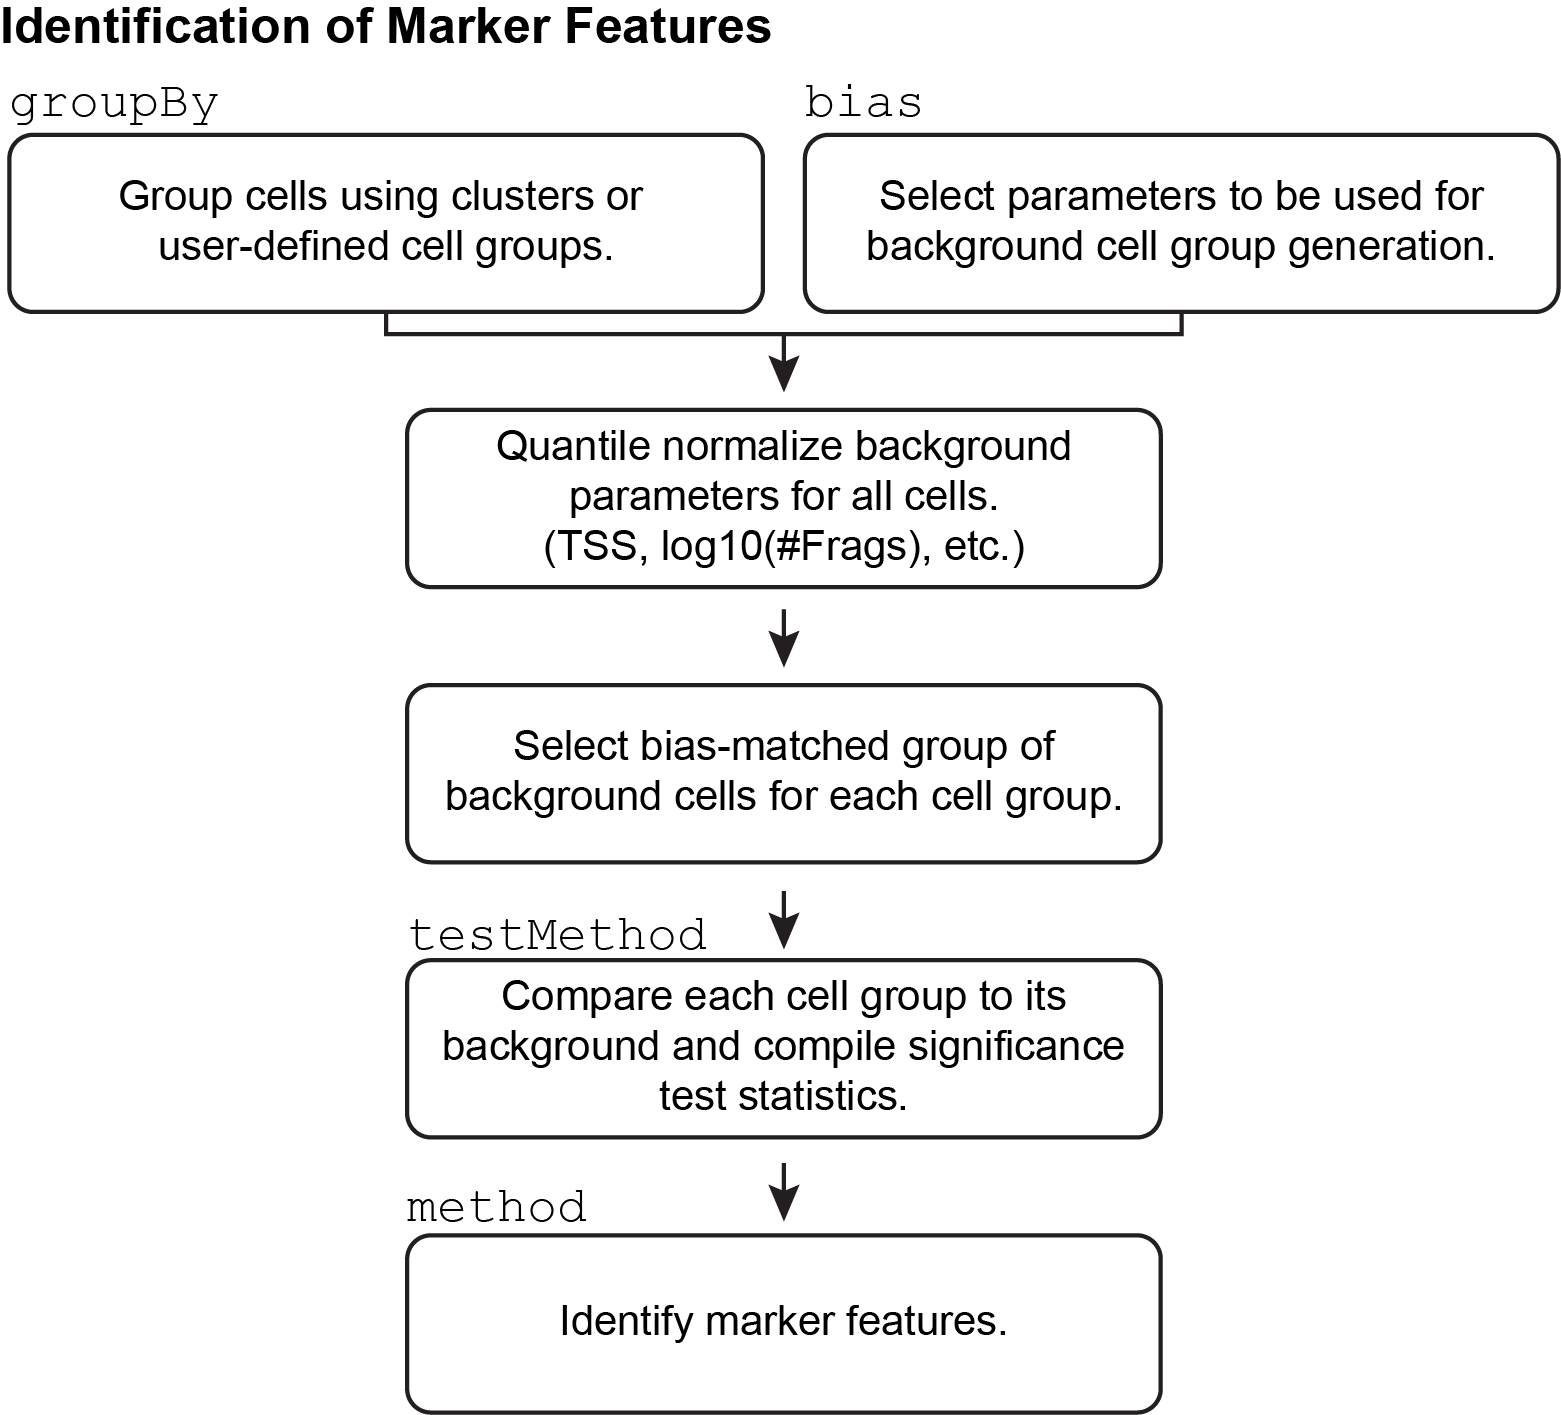

In [7]:
display_png(file="markerFeature_schematic.png", height = 600, width = 600) 

The selection of these background cell groups is critical to the success of this process and is performed across the multi-dimensional space provided by the user via the bias argument to `getMarkerFeatures()`. For each cell in the cell group, `ArchR` finds the nearest neighbor cell across the provided multi-dimensional space that is not a member of the given cell group and adds it to the background group of cells. In this way, `ArchR` creates a group of bias-matched cells that is as similar as possible to the given cell group, thus enabling a more robust determination of significance even if the group of cells is small.

The way ArchR does this is by taking all of the dimensions provided via the bias parameter and quantile normalizing their values to distribute the variance of each dimension across the same relative scale.


To identify marker genes based on gene scores, we call the `getMarkerFeatures()` function with `useMatrix = "GeneScoreMatrix"`. We specify that we want to know the cluster-specific features with `groupBy = "Clusters"` which tells ArchR to use the `“Clusters”` column in `cellColData` to stratify cell groups.


In [ ]:
markersGS <- getMarkerFeatures(
    ArchRProj = archr_multiome_proj, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon",
    verbose = FALSE
)

This function returns a `SummarizedExperiment` object containing relevant information on the marker features identified. This type of return value is common in ArchR and is one of the key ways that ArchR enables downstream data analysis. `SummarizedExperiment` objects are similar to a matrix where rows represent features of interest (i.e. genes) and columns represent samples. A `SummarizedExperiment` object contains one or more assays, each represented by a matrix-like object of numeric data, and metadata that applies to the rows or columns of the assays matrices. It is beyond the scope of this tutorial to dive into `SummarizedExperiment` objects but check out the bioconductor page if you need more information.

We can get a list of DataFrame objects, one for each of our clusters, containing the relevant marker features using the `getMarkers()` function:

In [ ]:
markersGS

In [ ]:
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.01 & Log2FC >= 1.25")
markerList$C6

In [ ]:
for(i in c(1:max(length(names(markerList))))){
    write.table(markerList[[i]], file=paste0("Combined_cluster_marker_geneScore/Jill_GeneScore_multiome_test_Upregulated_LFC_1.25_Cluster",i,".tsv"), sep="\t", quote=FALSE, col.names=NA)
}

# 4. GeneExpression Matrix

It is a Mutliome so we do not need to integgrate the value

In [ ]:
getAvailableMatrices(archr_multiome_proj)

In [ ]:
markersGE <- getMarkerFeatures(
    ArchRProj = archr_multiome_proj, 
    useMatrix = "GeneExpressionMatrix", 
    groupBy = "Clusters_RNA",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon",
    verbose = FALSE
)

This function returns a `SummarizedExperiment` object containing relevant information on the marker features identified. This type of return value is common in ArchR and is one of the key ways that ArchR enables downstream data analysis. `SummarizedExperiment` objects are similar to a matrix where rows represent features of interest (i.e. genes) and columns represent samples. A `SummarizedExperiment` object contains one or more assays, each represented by a matrix-like object of numeric data, and metadata that applies to the rows or columns of the assays matrices. It is beyond the scope of this tutorial to dive into `SummarizedExperiment` objects but check out the bioconductor page if you need more information.

We can get a list of DataFrame objects, one for each of our clusters, containing the relevant marker features using the `getMarkers()` function:

In [ ]:
#markersGE

In [ ]:
markerList <- getMarkers(markersGE, cutOff = "FDR <= 0.01 & Log2FC >= 1.25")
markerList$C6

In [ ]:
for(i in c(1:max(length(names(markerList))))){
    write.table(markerList[[i]], file=paste0("Combined_cluster_marker_geneExpression/Jill_GeneExpression_multiome_test_Upregulated_LFC_1.25_Cluster",i,".tsv"), sep="\t", quote=FALSE, col.names=NA)
}

In [ ]:
archr_multiome_proj <- loadArchRProject('multiome_lit_aggr')

we add impute weights to our project:

In [ ]:
markerGenes  <- c(
    "E2F7", 
    "HNF4A", #Parenchymal
    "ONECUT1", 
    "CRB1",
    "CPEB4", #Monocytes
    "PAX5",
    "NDC1",
    "STAB2",
    "GATA6",
    "PTPRC"
    #"MAS1" #TCells
  )

p1 <- plotEmbedding(
    ArchRProj = archr_multiome_proj, 
    colorBy = "GeneExpressionMatrix", 
    name = markerGenes, 
    continuousSet = "horizonExtra",
    embedding = "UMAP_Combined"
    #imputeWeights = getImputeWeights(aoibAggrproj)
)


p2 <- plotEmbedding(
    ArchRProj = archr_multiome_proj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    continuousSet = "horizonExtra",
    embedding = "UMAP_Combined"
    #imputeWeights = getImputeWeights(aoibAggrproj)
)

In [ ]:
options(repr.plot.width=14, repr.plot.height=16)
p1c <- lapply(p1, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 12) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

p2c <- lapply(p2, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 12) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))
do.call(cowplot::plot_grid, c(list(ncol = 3), p2c))

In [ ]:
pdf('multiome_aggr/Plots/geneExpression_Combined_UMAP.pdf')
do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))
do.call(cowplot::plot_grid, c(list(ncol = 3), p2c))
dev.off()

In [ ]:
markerGenes  <- c(
    "STAB2", 
    "HNF4A", #Parenchymal
    "SHANK2", 
    "GATA6",
    "HHIP", #Monocytes
    "CSF1R",
    "PTPRC",
    "GATA2"
  )

p1 <- plotEmbedding(
    ArchRProj = archr_multiome_proj, 
    colorBy = "GeneExpressionMatrix", 
    name = markerGenes, 
    continuousSet = "horizonExtra",
    embedding = "UMAP_Combined"
    #imputeWeights = getImputeWeights(aoibAggrproj)
)


p2 <- plotEmbedding(
    ArchRProj = archr_multiome_proj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    continuousSet = "horizonExtra",
    embedding = "UMAP_Combined"
    #imputeWeights = getImputeWeights(aoibAggrproj)
)

In [ ]:
options(repr.plot.width=14, repr.plot.height=16)
p1c <- lapply(p1, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 12) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

p2c <- lapply(p2, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 12) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))
do.call(cowplot::plot_grid, c(list(ncol = 3), p2c))

In [ ]:
pdf('multiome_aggr/Plots/geneExpression_Combined_UMAP_selected_genes.pdf')
do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))
do.call(cowplot::plot_grid, c(list(ncol = 3), p2c))
dev.off()

# 5. Calling Peaks with ArchR

Calling peaks is one of the most fundamental processes in ATAC-seq data analysis. Because per-cell scATAC-seq data is essentially binary (accessible or not accessible), we cannot call peaks on an individual cell basis. For this reason, we defined groups of cells, typically clusters, in a previous chapter. Moreover, we created pseudo-bulk replicates to allow us to assess the reproducibility of our peak calls.

We first introduced a strategy for [iterative overlap peak merging in 2018](https://science.sciencemag.org/content/362/6413/eaav1898). Other peak merging strategies suffer from a few key issues that we outline below.

### Fixed-width vs Variable-width Peaks

We use 501-bp fixed-width peaks because they make downstream computation easier as peak length does not need to be normalized. Moreover, the vast majority of peaks in ATAC-seq are less than 501-bp wide. Using variable-width peaks also makes it difficult to merge peak calls from multiple samples. In general, we do not feel that the potential benefit derived from using variable-width peaks outweighs the costs. More broadly, most analyses are stable with respect to the peak set or peak style used.


### Iterative Overlap In ArchR

Iterative overlap removal avoids the issues mentioned above. Peaks are first ranked by their significance. The most significant peak is retained and any peak that directly overlaps with the most significant peak is removed from further analysis. Then, of the remaining peaks, this process is repeated until no more peaks exist. This avoids daisy-chaining and still allows for use of fixed-width peaks.


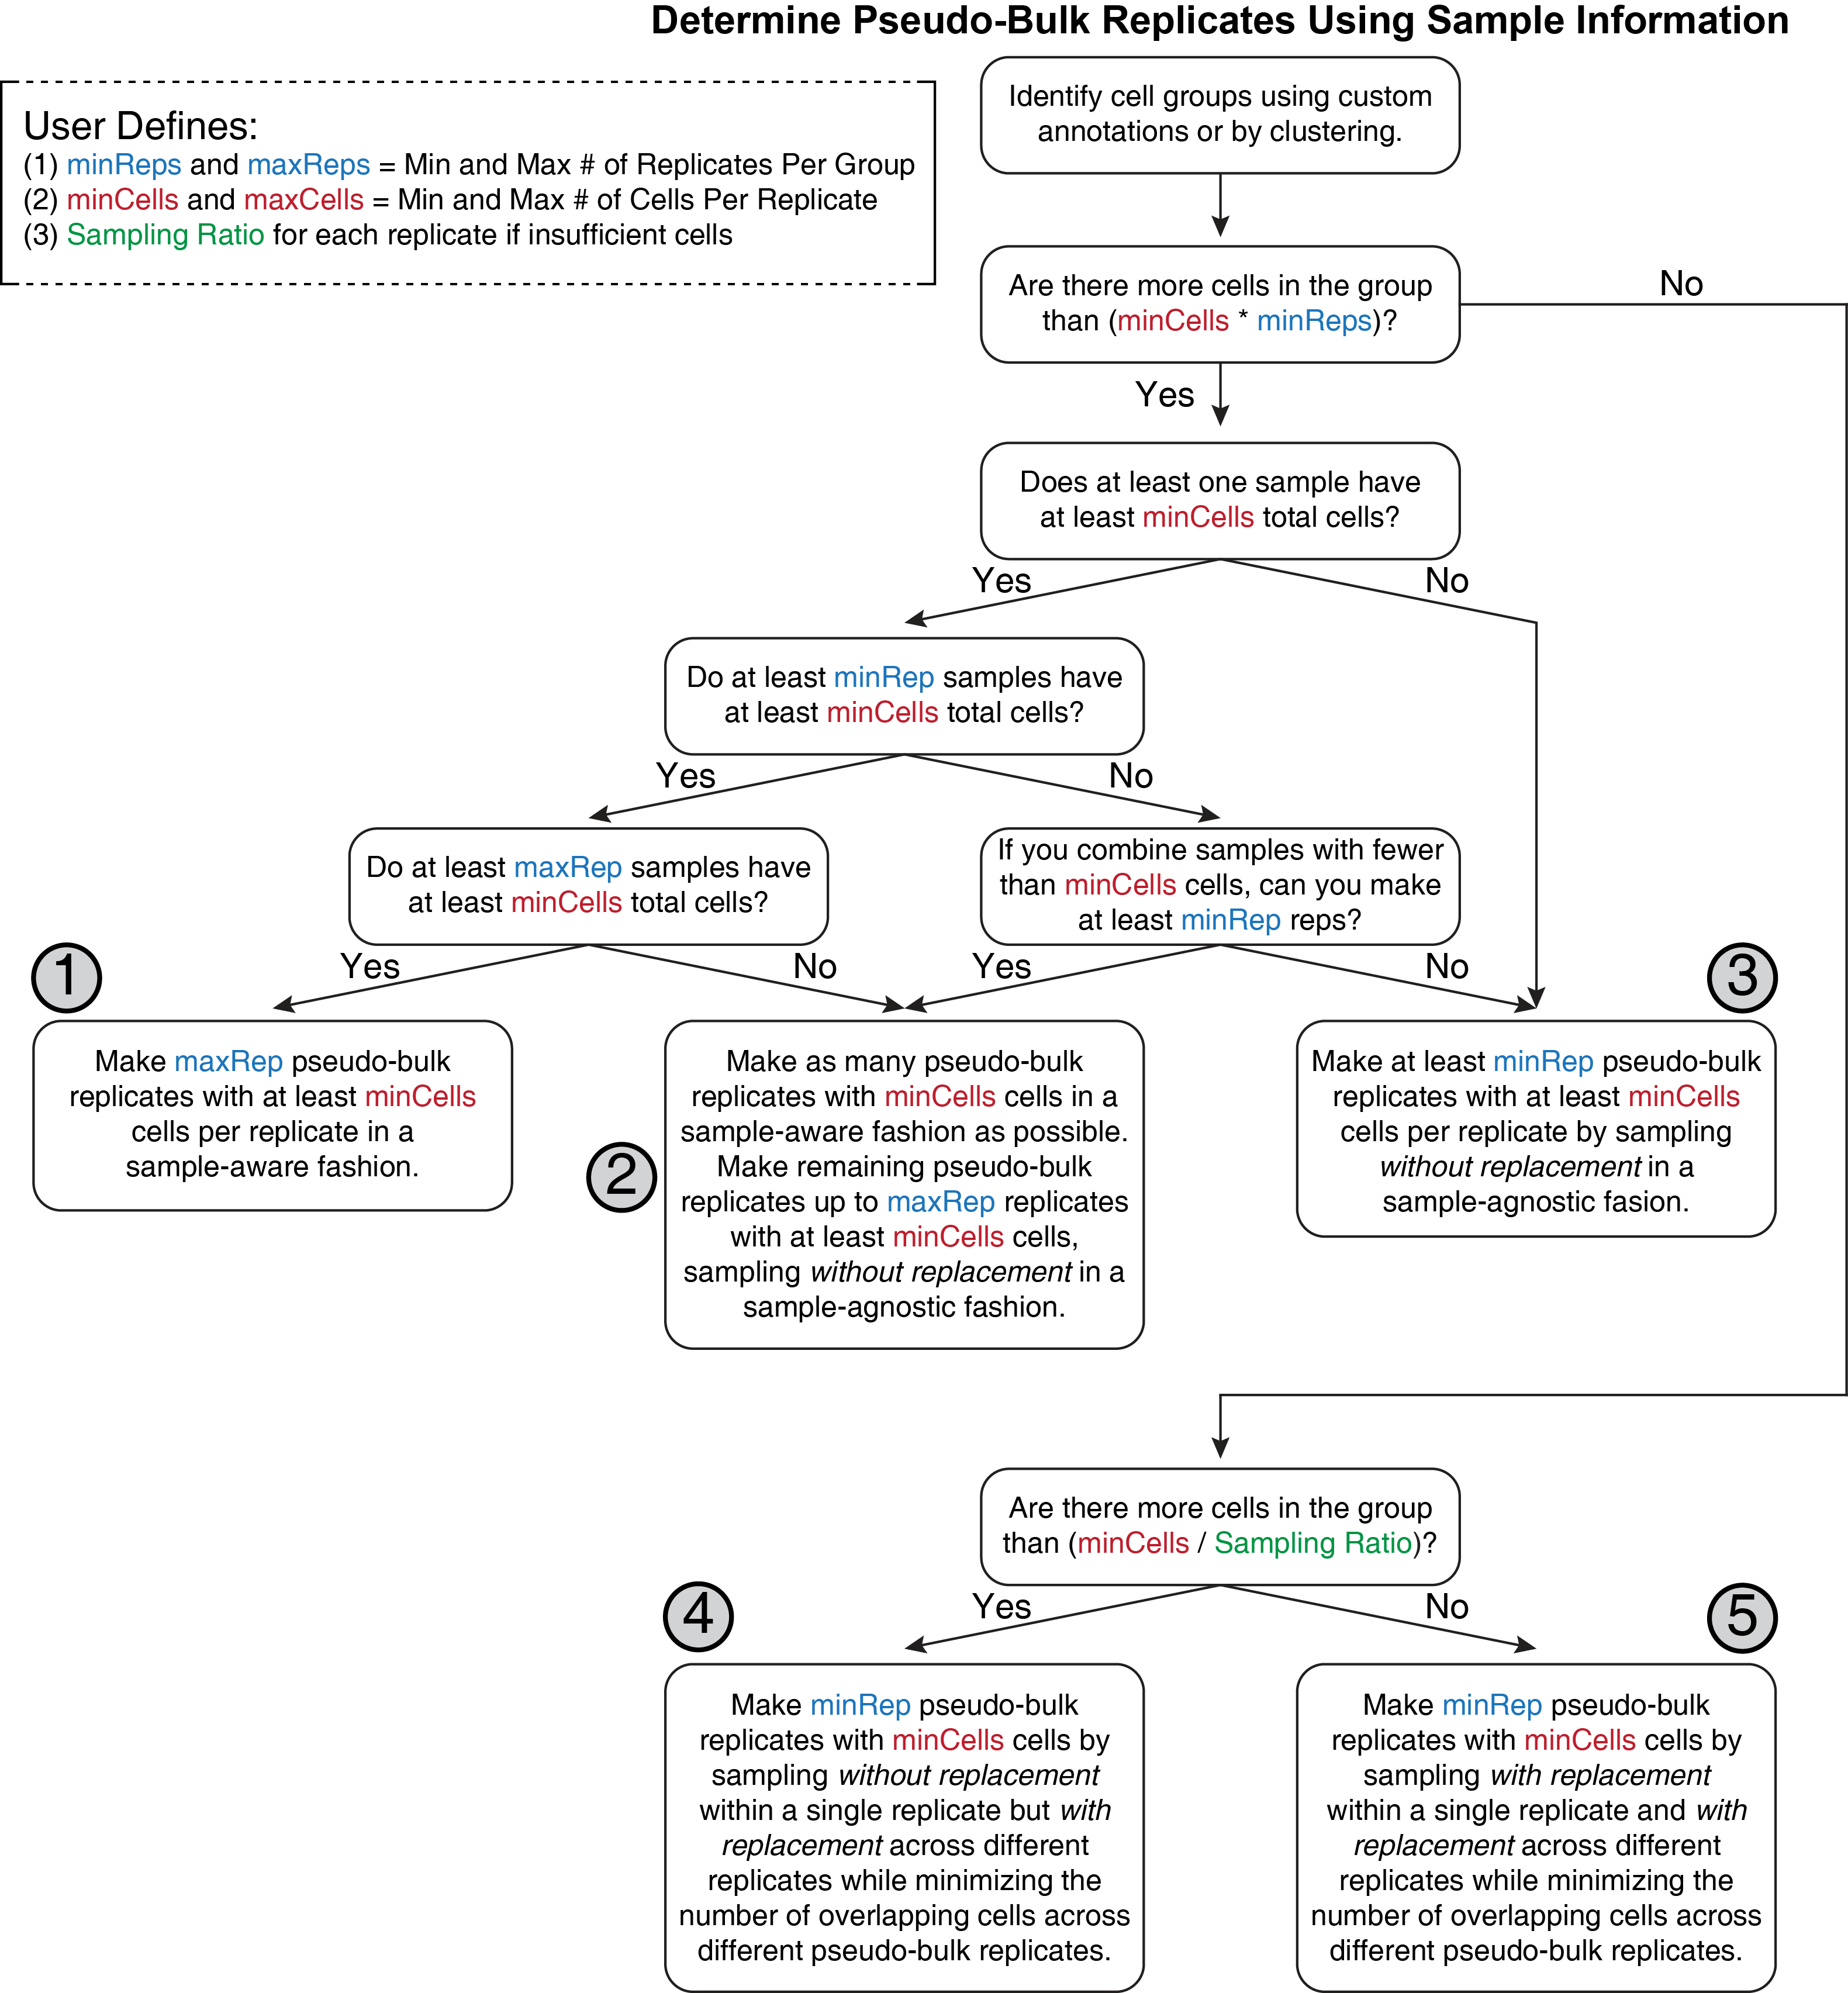

In [8]:
display_png(file="pseudobulkReplicate_DecisionTree.png", height = 800, width = 800) 

As mentioned above, we generate a reproducible peak set in ArchR using the `addReproduciblePeakSet()` function. By default ArchR attempts to call peaks using `MACS2`; however, ArchR also implements its own native peak caller which could be used when `MACS2` cannot be installed (for example, we have not successfully installed `MACS2` on Windows) - this alternative peak calling method is described in the next section.

To call peaks using `MACS2`, ArchR must be able to find the `MACS2` executable. First, ArchR looks in your PATH environment variable. If this is unsuccessful, ArchR attempts to determine if you have installed MACS2 with either `pip` or `pip3`. If neither of these is successful, ArchR gives up and provides an error message. If you have MACS2 installed and ArchR cannot find it, you should provide the path to the `addReproduciblePeakSet()` function via the `pathToMacs2` parameter.

With the path to `MACS2` identified, we can then create a reproducible merged peak set w/ MACS2 (~5-10 minutes). To avoid bias from pseudo-bulk replicates that have very few cells, we can provide a cutoff for the upper limit of the number of peaks called per cell via the `peaksPerCell` parameter. This prevents clusters with very few cells from contributing lots of low quality peaks to the merged peak set. There are many other parameters that can be tweaked in `addReproduciblePeakSet()`.

Each `ArchRProject` object can only contain a **single peak set**. As such, we assign the output of `addReproduciblePeakSet()` to our desired `ArchRProject`. If you would like to experiment with different peak sets, you must save a copy of your ArchRProject and thus also copy the Arrow files. While this does use more on-disk storage space, this is unavoidable given the structure of Arrow files and the storage of peak matrix information in the Arrow files.

In [ ]:
pathToMacs2 <- findMacs2()

In [ ]:
pathToMacs2

In [ ]:
addArchRThreads(threads = 1)

In [ ]:
archr_multiome_proj <- addGroupCoverages(archr_multiome_proj, groupBy = "Clusters", verbose=FALSE)

In [ ]:
addArchRThreads(threads = 1)

In [ ]:
archr_multiome_proj <- addReproduciblePeakSet(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Clusters", # We are calling with clusters defined by tiles, 
                           # but can be called with Cluster2 which is the cluster from snRNA-seq
    peakMethod = "Macs2",
    pathToMacs2 = pathToMacs2
)

In [ ]:
archr_multiome_proj <- addPeakMatrix(archr_multiome_proj, verbose=FALSE)

In [ ]:
getAvailableMatrices(archr_multiome_proj)

We save the projects with the peak

In [ ]:
saveArchRProject(ArchRProj = archr_multiome_proj, outputDirectory = "multiome_aggr_combinedCluster_peaks", load = FALSE)

## 5.2 Identifying Marker Peaks with ArchR

We have introduced the identification of marker features previously in the chapter discussing gene scores. The same function (`getMarkerFeatures()`) can be used to identify marker features from any matrix stored in an `ArchRProject`. Marker features are features that are unique to a specific cell grouping. These can be very useful in understanding cluster- or cell type-specific biology. 

### Identifying Marker Peaks with ArchR

Often times, we are interested to know which peaks are unique to an individual cluster or a small group of clusters. We can do this in an unsupervised fashion in ArchR using the `addMarkerFeatures()` function in combination with `useMatrix = "PeakMatrix"`.


In [ ]:
markersPeaks <- getMarkerFeatures(
    ArchRProj = archr_multiome_proj, 
    useMatrix = "PeakMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon",
    verbose = FALSE
)

In [ ]:
saveRDS(markersPeaks,'markersPeaks.rds')

In [ ]:
markersPeaks <- readRDS('markersPeaks.rds')

In [ ]:
markerPeakList <- getMarkers(markersPeaks, cutOff = "FDR <= 0.01 & Log2FC >= 1")
markerPeakList

In [ ]:
for(i in c(1:max(length(names(markerPeakList))))){
    write.table(markerPeakList[[i]], file=paste0("Combined_cluster_markerPeaks/Jill_Multiome_aggr_Peak_Upregulated_OnCombinedClusters_LFC_1.25_Cluster",i,".tsv"), sep="\t", quote=FALSE, col.names=NA)
}

In [ ]:
heatmapPeaks <- plotMarkerHeatmap(
  seMarker = markersPeaks, 
  cutOff = "FDR <= 0.1 & Log2FC >= 0.5",
    #labelMarkers = rownames(markersPeaks),
  transpose = TRUE
)

In [ ]:
pma <- plotMarkers(seMarker = markersPeaks, name = "C8", cutOff = "FDR <= 0.1 & Log2FC >= 1", plotAs = "MA")
pma

In [ ]:
pv <- plotMarkers(seMarker = markersPeaks, name = "C8", cutOff = "FDR <= 0.1 & Log2FC >= 1", plotAs = "Volcano")
pv

In [ ]:
makerPeakAndy <- c('HNF4A', 'GATA6')

In [ ]:
p <- plotBrowserTrack(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Clusters", 
    geneSymbol = makerPeakAndy,     
    upstream = 50000,
    downstream = 50000,
    loops = getCoAccessibility(archr_multiome_proj),
    verbose = FALSE
)

In [ ]:
options(repr.plot.width=18, repr.plot.height=10)
grid::grid.draw(p$Hnf4a)

In [ ]:
plotPDF(plotList = p, 
    name = "Plot-Tracks-TF-with-CoAccessibility.pdf", 
    ArchRProj = archr_multiome_proj, 
    addDOC = FALSE, width = 5, height = 5)

## 5.3 Motif and Feature Enrichment with ArchR

After identification of a robust peak set, we often want to predict what transcription factors may be mediating the binding events that create those accessible chromatin sites. This can be helpful in assessing marker peaks or differential peaks to understand if these groups of peaks are enriched for binding sites of specific transcription factors. For example, we often find enrichment of key lineage-defining TFs in cell type-specific accessible chromatin regions. In a similar fashion, we might want to test various groups of peaks for enrichment of other known features. For example, we might want to know if cell type-specific ATAC-seq peaks for cell type A are enriched for another set of genomic regions such as ChIP-seq peaks. This chapter details how these enrichments are performed in ArchR.

### Motif Enrichment in Differential Peaks

We now look for motifs that are enriched in peaks that are up or down in various cell types. To do this, we must first add these motif annotations to our `ArchRProject`. This effectively creates a binary matrix where the presence of a motif in each peak is indicated numerically. We do this using the `addMotifAnnotations()` function which determines motif presence in the peak set stored in the ArchRProject.

In [ ]:
archr_multiome_proj <- addMotifAnnotations(ArchRProj = archr_multiome_proj, motifSet = "cisbp", name = "Motif", force=TRUE)

In [ ]:
archr_multiome_proj <- addDeviationsMatrix(archr_multiome_proj, peakAnnotation = "Motif", force = TRUE)

In [ ]:
enrichMotifs <- peakAnnoEnrichment(
    seMarker = markersPeaks, # markerpeakss identified in the previous section
    ArchRProj = archr_multiome_proj,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.1 & Log2FC >= 0.5"
  )

In [ ]:
heatmapEM <- plotEnrichHeatmap(enrichMotifs, n = 10, transpose = TRUE)

In [ ]:
heatmapEM_MM <- plotEnrichHeatmap(enrichMotifs, n = 10, transpose = TRUE, returnMatrix = TRUE)

In [ ]:
library(pheatmap)

In [ ]:
options(repr.plot.width=18, repr.plot.height=6)
pheatmap(heatmapEM_MM, color = paletteContinuous(set = "comet", n = 100))

In [ ]:
heatmapEM_MM <- plotEnrichHeatmap(enrichMotifs, n = 20, transpose = TRUE, returnMatrix = TRUE)

In [ ]:
p1 <- pheatmap(heatmapEM_MM, color = paletteContinuous(set = "comet", n = 100))

In [ ]:
plotPDF(p1, name = "Motifs-Enriched-Marker-Heatmap", width = 18, height = 6, 
        ArchRProj = Aoib_w15_proj_multiome, addDOC = FALSE)

In [ ]:
png('multiome_15W/Plots/Motifs-Enriched-Marker-Heatmap.png', width=1800, height=600, res=100)
p1
dev.off()

## 5.4 ChromVAR Deviatons Enrichment with ArchR

As shown in previous chapters, TF motif enrichments can help us predict which regulatory factors are most active in our cell type of interest. These enrichments, however, are not calculated on a per-cell basis and they do not take into account the insertion sequence bias of the Tn5 transposase. chromVAR, an R packaged from the Greenlead Lab, was created to account for these issues. chromVAR is designed for predicting enrichment of TF activity on a per-cell basis from sparse chromatin accessibility data. The two primary outputs of chromVAR are:

1. “deviations” - A deviation is a bias-corrected measurement of how far the per-cell accessibility of a given feature (i.e motif) deviates from the expected accessibility based on the average of all cells or samples.
2. “z-score” - The z-score, also known as a “deviation score” is the z-score for each bias-corrected deviation across all cells. The absolute value of the deviation score is correlated with the per-cell read depth. This is because, with more reads, you have higher confidence that the difference in per-cell accessibility of the given feature (i.e. motif) from the expectation is greater than would occur by chance.

One of the primary limitations of chromVAR is that it was designed during the early era of scATAC-seq data generation when an experiment consisted of a few hundred of cells. At this experimental scale, chromVAR could easily read the entire cell-by-peak matrix into memory to quickly compute TF deviations. However, current experimental approaches use tens to hundreds of thousands of cells, generating cell-by-peak matrices that are much more difficult to read into memory. This leads to dramatic increases in run time and memory usage for even moderately sized datasets of 50,000 cells.

To circumvent these limitations, ArchR implements the same chromVAR analysis workflow by analyzing sample sub-matrices independently.

First, ArchR reads in the global accessibility per peak across all cells in each sub-sample. Second, for each peak, ArchR identifies a set of background peaks that are matched by GC-content and accessibility. Third, ArchR uses this background set of peaks and global accessibility to compute bias-corrected deviations with chromVAR for each sample independently. This implementation requires data from only 5,000-10,000 cells to be loaded into memory at any given time, minimizing the memory requirements, enabling scalable analysis with chromVAR, and improving run-time performance.

### Motif Deviations

First, lets make sure we have added motif annotations to our ArchRProject.


In [ ]:
if("Motif" %ni% names(archr_multiome_proj@peakAnnotation)){
    archr_multiome_proj <- addMotifAnnotations(ArchRProj = archr_multiome_proj, motifSet = "cisbp", name = "Motif")
}

We also need to add a set of background peaks which are used in computing deviations. Background peaks are chosen using the `chromVAR::getBackgroundPeaks()` function which samples peaks based on similarity in GC-content and number of fragments across all samples using the Mahalanobis distance.

In [ ]:
archr_multiome_proj <- addBgdPeaks(archr_multiome_proj, force=TRUE)

We are now ready to compute per-cell deviations accross all of our motif annotations using the `addDeviationsMatrix()` function. This function has an optional parameter called `matrixName` that allows us to define the name of the deviations matrix that will be stored in the Arrow files. If we do not provide a value to this parameter, as in the example below, this function creates a matrix name by adding the word “Matrix” to the name of the peakAnnotation. The example below creates a deviations matrix in each of our Arrow files called “MotifMatrix”.

In [ ]:
archr_multiome_proj <- addDeviationsMatrix(
  ArchRProj = archr_multiome_proj, 
  peakAnnotation = "Motif",
  force = TRUE
)

To access these deviations, we use the `getVarDeviations()` function. If we want this function to return a `ggplot` object, we set `plot = TRUE` otherwise, this function would return the `DataFrame` object. The head of that `DataFrame` object is displayed by default when the function is run.

In [ ]:
plotVarDev <- getVarDeviations(archr_multiome_proj, name = "MotifMatrix", plot = TRUE)

From the above snapshot of the DataFrame, you can see that the seqnames of the `MotifMatrix` are not chromosomes. Typically, in matrices like the `TileMatrix`, `PeakMatrix`, and `GeneScoreMatrix`, we store the chromosome information in seqnames. The `MotifMatrix` does not have any corresponding position information but, instead, stores both the “devations” and “z-scores” from `chromVAR` into the same matrix using two different seqnames - deviations and z. This becomes important later on if you try to use the `MotifMatrix` (which is of class `Sparse.Assays.Matrix`) in functions such as `getMarkerFeatures()`. In these types of operations, ArchR will expect you to subset `MotifMatrix` to one of the two seqnames (i.e. select either z-scores or deviations to perform calculations).

We can then plot these variable deviations.

In [ ]:
plotVarDev

To save an editable vectorized version of this plot, we use the plotPDF() function.

What if we want to extract a subset of motifs for downstream analysis? We can do this using the getFeatures() function. The paste(motifs, collapse="|") statement below creates a concatenated or statement that enables selection of all of the motifs.

Instead of looking at the distributions of these z-scores, we can overlay the z-scores on our UMAP embedding as we’ve done previously for gene scores.

In [ ]:
p <- plotEmbedding(
    ArchRProj = archr_multiome_proj, 
    colorBy = "MotifMatrix", 
    name = sort(markerMotifs), 
    embedding = "UMAP_Combined",
    imputeWeights = getImputeWeights(archr_multiome_proj)
)

We can plot all of these motif UMAPs using `cowplot`.

In [ ]:
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

To see how these TF deviation z-scores compare to the inferred gene expression via gene scores of the corresponding TF genes, we can overlay the gene scores for each of these TFs on the UMAP embedding.

Similarly, because we previously linked our scATAC-seq data with corresponding scRNA-seq data, we can plot the linked gene expression for each of these TFs on the UMAP embedding.

In [ ]:
saveArchRProject(ArchRProj = archr_multiome_proj)

# 6 Footprinting with ArchR

You can do Footprinting with ArchR as well but I will not show it here.

# 7. Co-accessibility with ArchR

Co-accessibility is a correlation in accessibility between two peaks across many single cells. Said another way, when Peak A is accessible in a single cell, Peak B is often also accessible. We illustrate this concept visually below, showing that Enhancer E3 is often co-accessible with Promoter P.


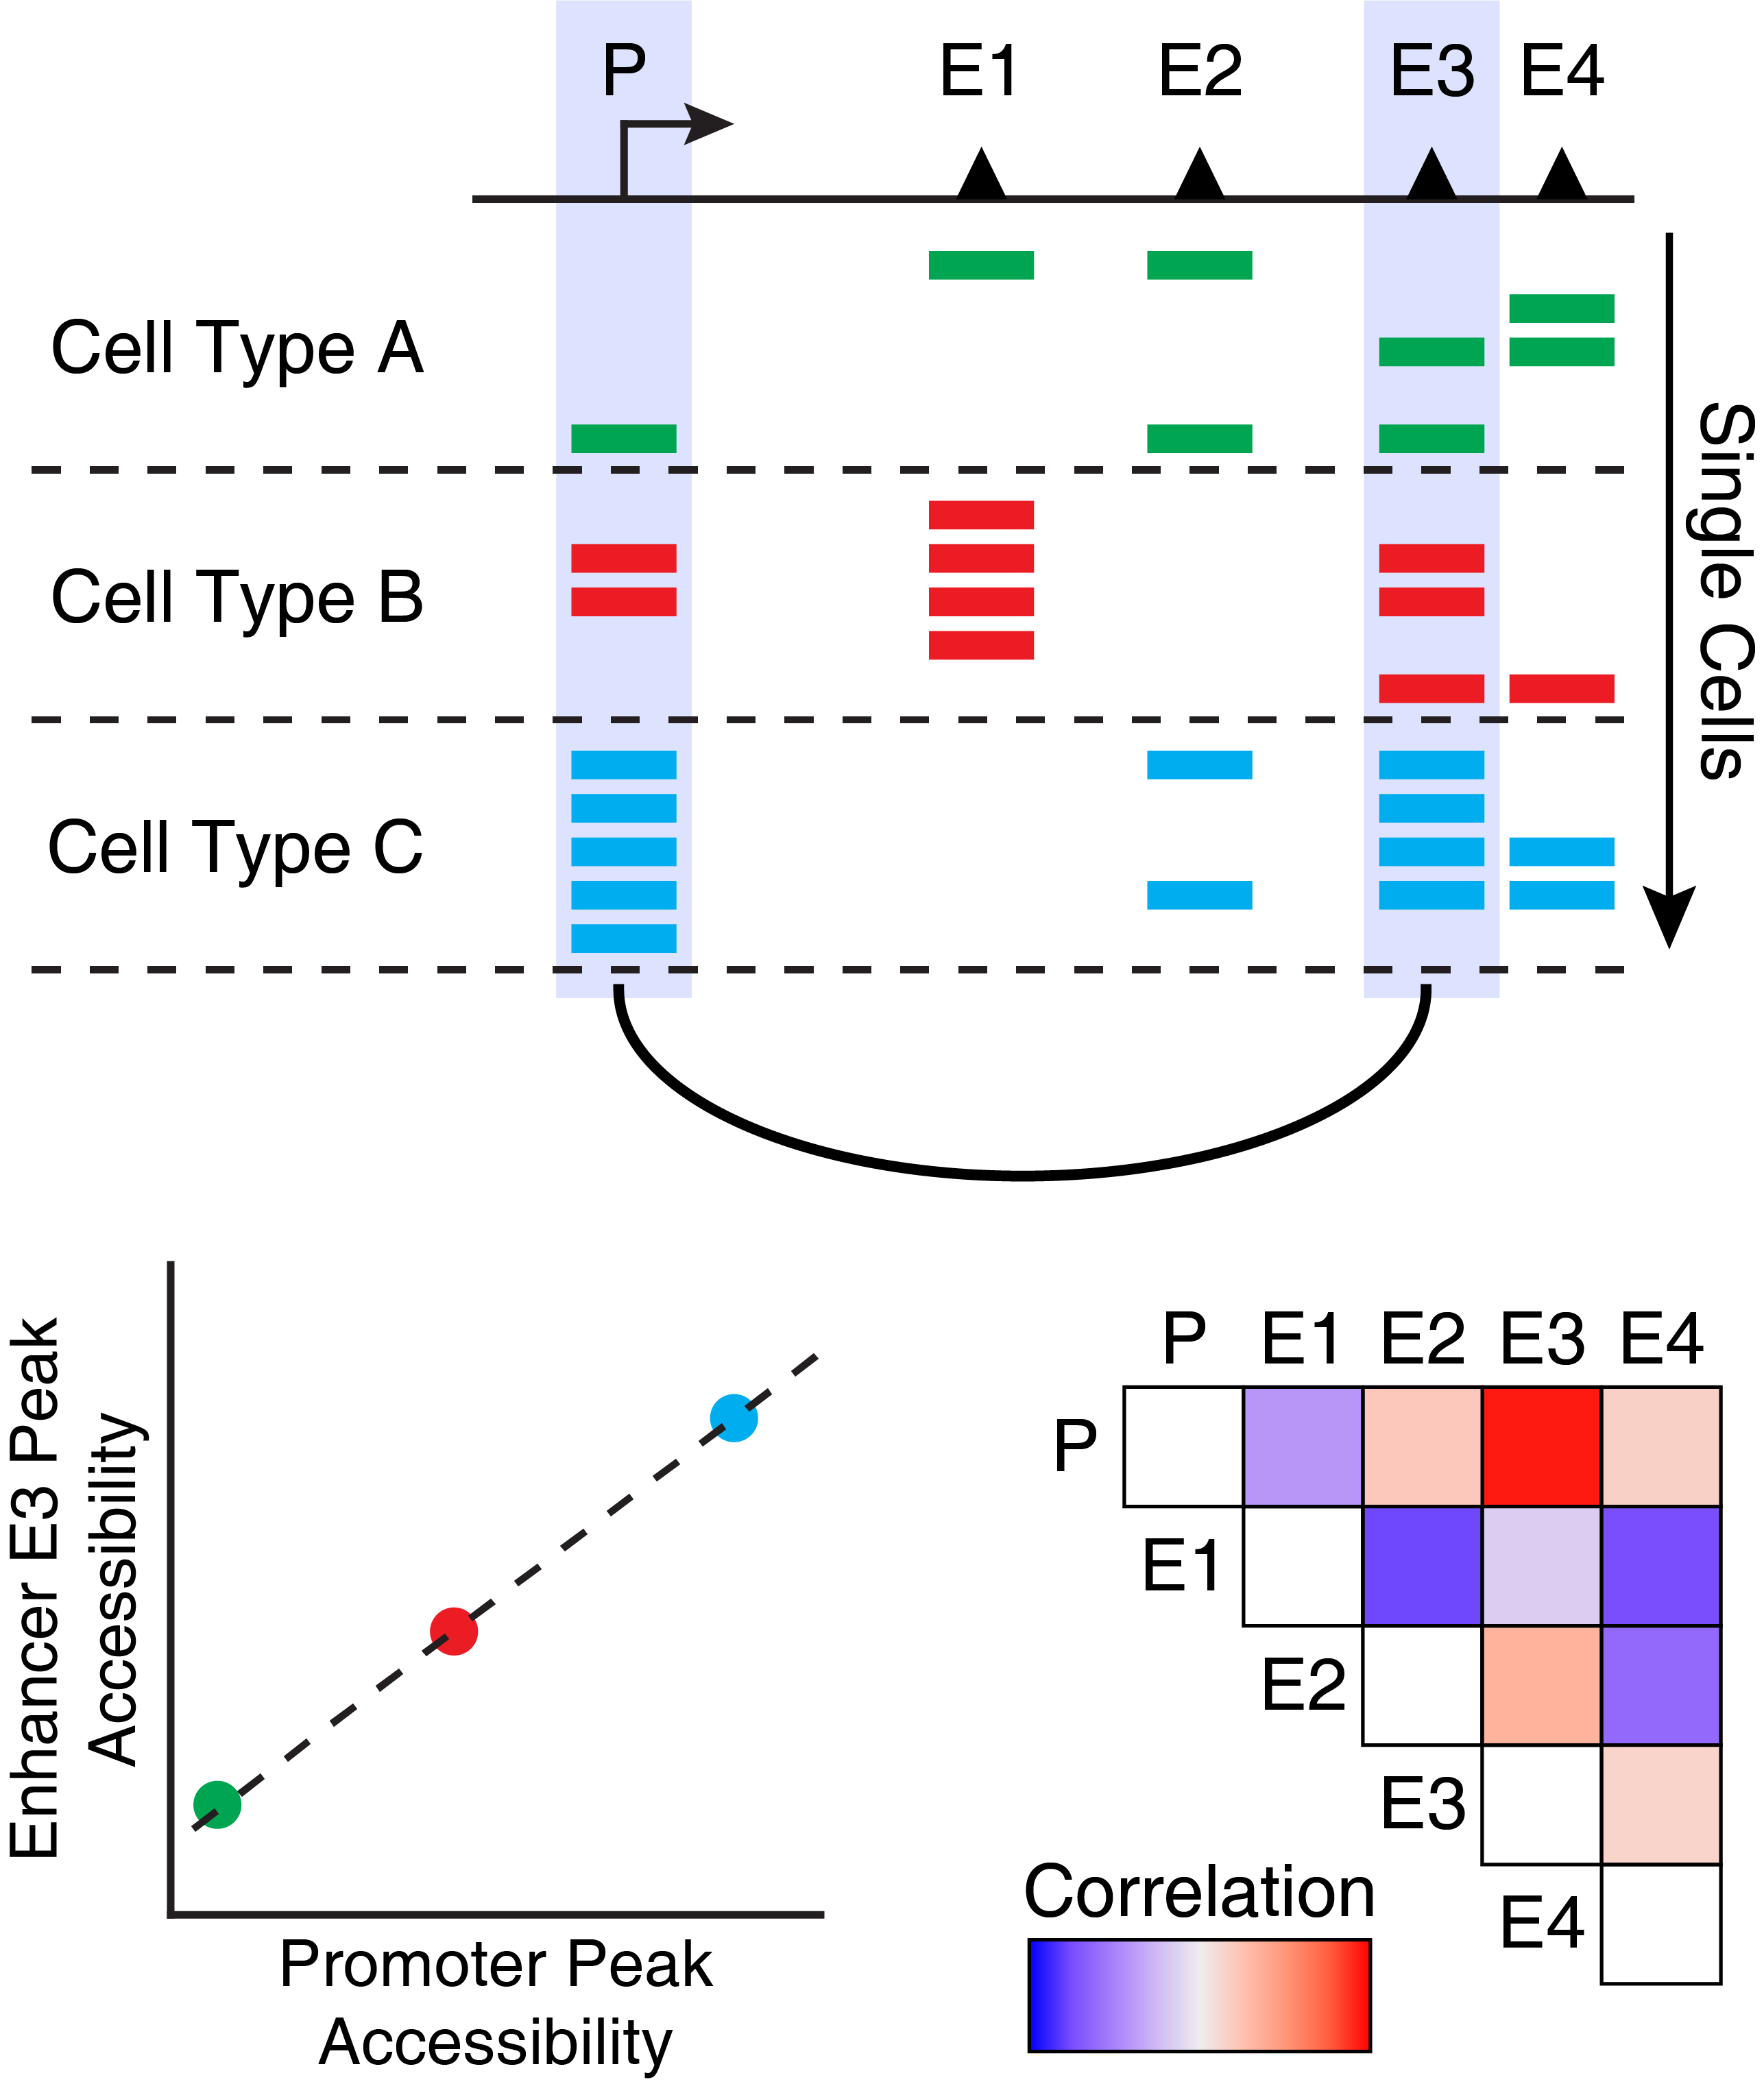

In [9]:
display_png(file="ArchR_Coaccessibility.png", height = 800, width=400)  

One thing to note about co-accessibility analysis is that it often identified cell type-specific peaks as being co-accessibile. This is because these peaks are often all accessible together within a single cell type and often all not accessible in all other cell types. This drives a strong correlation but does not necessarily mean that there is a regulatory relationship between these peaks.

To calculate co-accessibility in ArchR, we use the `addCoAccessibility()` function which stores peak co-accessibility information in the ArchRProject.

In [ ]:
archr_multiome_proj <- addCoAccessibility(
    ArchRProj = archr_multiome_proj,
    reducedDims = "LSI_Combined",
    verbose = FALSE
)

We can retrieve this co-accessibility information from the ArchRProject via the `getCoAccessibility()` function which returns a DataFrame object if `returnLoops = FALSE`.

In [ ]:
cA <- getCoAccessibility(
    ArchRProj = archr_multiome_proj,
    corCutOff = 0.5,
    resolution = 1000,
    returnLoops = TRUE
)

cA[[1]]

In [ ]:
markerGenes  <- c(
    "Gata6",
    "Sox9"
  )

p <- plotBrowserTrack(
    ArchRProj = archr_multiome_proj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000,
    loops = getCoAccessibility(archr_multiome_proj),
    verbose = FALSE
)

In [ ]:
options(repr.plot.width=8, repr.plot.height=10)
grid::grid.newpage()
grid::grid.draw(p$Gata6)

### Peak2GeneLinkage with ArchR
Similar to co-accessibility, ArchR can also identify so-called “peak-to-gene links”. The primary differences between peak-to-gene links and co-accessibility is that co-accessibility is an ATAC-seq-only analysis that looks for correlations in accessibility between two peaks while peak-to-gene linkage leverages integrated scRNA-seq data to look for correlations between peak accessibility and gene expression. These represent orthogonal approaches to a similar problem. However, because peak-to-gene linkage correlates scATAC-seq and scRNA-seq data, we often think of these links as more relevant to gene regulatory interactions.

## Generating bigWig files

In [ ]:
getGroupBW(ArchRProj = archr_multiome_proj,
          groupBy = "Clusters",
          normMethod = "ReadsInTSS",
          tileSize = 100,
          maxCells = 1000)

In [ ]:
getGroupBW(ArchRProj = archr_multiome_proj,
          groupBy = "Sample",
          normMethod = "ReadsInTSS",
          tileSize = 100,
          maxCells = 1000)

In [ ]:
getGroupBW(ArchRProj = archr_multiome_proj,
          groupBy = "Clusters",
          normMethod = "ReadsInTSS",
          tileSize = 100,
          maxCells = 1000)

## 7. Identification of Positive TF-Regulators

ATAC-seq allows for the unbiased identification of TFs that exhibit large changes in chromatin accessibility at sites containing their DNA binding motifs. However, families of TFs (for ex. GATA factors) share similar features in their binding motifs when looking in aggregate through position weight matrices (PWMs).

This motif similarity makes it challenging to identify the specific TFs that might be driving observed changes in chromatin accessibility at their predicted binding sites. To circumvent this challenge, we have previously ATAC-seq and RNA-seq to identify TFs whose gene expression is positively correlated to changes in the accessibility of their corresponding motif. We term these TFs “positive regulators”. However, this analysis relies on matched gene expression data which may not be readily available in all experiments. To overcome this dependency, ArchR can identify TFs whose inferred gene scores are correlated to their chromVAR TF deviation z-scores. To achieve this, ArchR correlates chromVAR deviation z-scores of TF motifs with gene activity scores of TF genes from the low-overlapping cell aggregates. When using scRNA-seq integration with ArchR, gene expression of the TF can be used instead of inferred gene activity score.

### Step 1. Identify Deviant TF Motifs

The first part of identifying positive TF regulators is identification of deviant TF motifs. We performed this analysis in a previous chapter, creating a MotifMatrix of chromVAR deviations and deviation z-scores for all motifs. We can obtain this data, averaged by clusters, by using the getGroupSE() function which returns a SummarizedExperiment.

In [ ]:
getAvailableMatrices(archr_multiome_proj)

In [ ]:
seGroupMotif <- getGroupSE(ArchRProj = archr_multiome_proj, useMatrix = "MotifMatrix", groupBy = "Clusters")

Because this `SummarizedExperiment` object comes from the `MotifMatrix` is has two seqnames - “deviations” and “z” - corresponding to the raw deviations and deviation z-scores from chromVAR.

In [ ]:
seGroupMotif

We can subset this `SummarizedExperiment` to just the deviation z-scores.

In [ ]:
seZ <- seGroupMotif[rowData(seGroupMotif)$seqnames=="z",]

Then we can identify the maximum delta in z-score between all clusters. This will be helpful in stratifying motifs based on the degree of variation observed across clusters.

In [ ]:
rowData(seZ)$maxDelta <- lapply(seq_len(ncol(seZ)), function(x){
  rowMaxs(assay(seZ) - assay(seZ)[,x])
}) %>% Reduce("cbind", .) %>% rowMaxs

### Step 2. Identify Correlated TF Motifs and TF Gene Score/Expression

To identify TFs whose motif accessibility is correlated with with their own gene activity (either by gene score or gene expression), we use the `correlateMatrices()` function and provide the two matrices that we are interested in, in this case the `GeneScoreMatrix` and the `MotifMatrix`. As mentioned previously, these correlations are determined across many low-overlapping cell aggregates determined in the lower dimension space specified in the reducedDims parameter.

In [ ]:
corGSM_MM <- correlateMatrices(
    ArchRProj = archr_multiome_proj,
    useMatrix1 = "GeneScoreMatrix",
    useMatrix2 = "MotifMatrix",
    reducedDims = "LSI_Combined"
)

We can perform the same analysis using the `GeneIntegrationMatrix` instead of the `GeneScoreMatrix`.

In [ ]:
corGIM_MM <- correlateMatrices(
    ArchRProj = archr_multiome_proj,
    useMatrix1 = "GeneExpressionMatrix",
    useMatrix2 = "MotifMatrix",
    reducedDims = "LSI_Combined"
)

In [ ]:
corGIM_MM

### Step 3. Add Maximum Delta Deviation to the Correlation Data Frame

For each of these correlation analyses, we can annotate each motif with the maximum delta observed between clusters which we calculated in Step 1.

In [ ]:
corGSM_MM$maxDelta <- rowData(seZ)[match(corGSM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]
corGIM_MM$maxDelta <- rowData(seZ)[match(corGIM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]

### Step 4. Identify Positive TF Regulators

We can use all of this information to identify positive TF regulators. In the examples below, we consider positive regulators as those TFs whose correlation between motif and gene score (or gene expression) is greater than 0.5 with an adjusted p-value less than 0.01 and a maximum inter-cluster difference in deviation z-score that is in the top quartile.

We apply these selection criteria and do a little text juggling to isolate the TF names.

In [ ]:
corGSM_MM <- corGSM_MM[order(abs(corGSM_MM$cor), decreasing = TRUE), ]
corGSM_MM <- corGSM_MM[which(!duplicated(gsub("\\-.*","",corGSM_MM[,"MotifMatrix_name"]))), ]

In [ ]:
corGSM_MM <- corGSM_MM[order(abs(corGSM_MM$cor), decreasing = TRUE), ]
corGSM_MM <- corGSM_MM[which(!duplicated(gsub("\\-.*","",corGSM_MM[,"MotifMatrix_name"]))), ]
corGSM_MM$TFRegulator <- "NO"
corGSM_MM$TFRegulator[which(corGSM_MM$cor > 0.5 & corGSM_MM$padj < 0.01 & corGSM_MM$maxDelta > quantile(corGSM_MM$maxDelta, 0.5))] <- "YES"
sort(corGSM_MM[corGSM_MM$TFRegulator=="YES",1])

Having identified these positive TF regulators from gene scores and motif deviation z-scores, we can highlight them in a dot plot.

In [ ]:
library(ggrepel)

In [ ]:
df <- data.frame(corGSM_MM)
p <- ggplot(df, aes(cor, maxDelta, color = TFRegulator)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Score") +
  ylab("Max TF Motif Delta") +
  geom_text_repel(aes(cor, maxDelta, label = GeneScoreMatrix_matchName), min.segment.length = 0.1)
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGSM_MM$maxDelta)*0.95)
  )

p

In [ ]:
pdf('multiome_aggr_combinedCluster_peaks/Plots/Correlation_with_Motif_GeneScore.pdf')
p
dev.off()

In [ ]:
corGIM_MM <- corGIM_MM[order(abs(corGIM_MM$cor), decreasing = TRUE), ]
corGIM_MM <- corGIM_MM[which(!duplicated(gsub("\\-.*","",corGIM_MM[,"MotifMatrix_name"]))), ]
corGIM_MM$TFRegulator <- "NO"
corGIM_MM$TFRegulator[which(corGIM_MM$cor > 0.5 & corGIM_MM$padj < 0.01 & corGIM_MM$maxDelta > quantile(corGIM_MM$maxDelta, 0.5))] <- "YES"
#sort(corGIM_MM[corGIM_MM$TFRegulator=="YES",1])

In [ ]:
df <- data.frame(corGIM_MM)
p <- ggplot(df, aes(cor, maxDelta, color = TFRegulator)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Expression") +
  ylab("Max TF Motif Delta") +
  geom_text_repel(aes(cor, maxDelta, label = GeneExpressionMatrix_matchName), min.segment.length = 0, max.overlaps=20, size=2.5)
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGSM_MM$maxDelta)*0.85)
  )

p

In [ ]:
pdf('multiome_aggr_combinedCluster_peaks/Plots/Correlation_with_Motif_GeneExpression.pdf')
p
dev.off()

In [ ]:
peakSetAll <- getPeakSet(archr_multiome_proj)

In [ ]:
write.csv(data.frame(peakSetAll), 'allPeaks.csv')

# Saving project

In [ ]:
saveArchRProject(ArchRProj = archr_multiome_proj)

In [ ]:
saveRDS(GE_matrix,'GE_matrix.RDS')

In [ ]:
UMAP_Combined <- getEmbedding(archr_multiome_proj, embedding = "UMAP_Combined", returnDF=TRUE)
UMAP_ATAC <- getEmbedding(archr_multiome_proj, embedding = "UMAP_ATAC", returnDF=TRUE)
UMAP_RNA <- getEmbedding(archr_multiome_proj, embedding = "UMAP_RNA", returnDF=TRUE)

In [ ]:
UMAP_Combined <- cbind(UMAP_Combined, colData(GE_matrix)[,c('Clusters','Clusters_ATAC','Clusters_RNA')])
UMAP_Combined

In [ ]:
write.table(UMAP_Combined, 'UMAP_Combined.tsv')

In [ ]:
UMAP_RNA <- cbind(UMAP_RNA, colData(GE_matrix)[,c('Clusters','Clusters_ATAC','Clusters_RNA')])
write.table(UMAP_RNA, 'UMAP_RNA.tsv')

In [ ]:
UMAP_ATAC <- cbind(UMAP_ATAC, colData(GE_matrix)[,c('Clusters','Clusters_ATAC','Clusters_RNA')])
write.table(UMAP_ATAC, 'UMAP_ATAC.tsv')

## Trajectory C3 -> C2 -> C1 (periderm)

In [ ]:

trajectory <- c("C3", "C2", "C1")
trajectory

archr_multiome_proj_subset <- addTrajectory(
    ArchRProj = archr_multiome_proj_subset, 
    name = "Periderm_trajectory_subset", 
    groupBy = "Clusters",
    trajectory = trajectory, 
    embedding = "UMAP_Combined", 
    force = TRUE
)

In [ ]:
p <- plotTrajectory(archr_multiome_proj_subset, embedding="UMAP_Combined", 
                    trajectory = "Periderm_trajectory_subset", colorBy = "cellColData", name = "Periderm_trajectory_subset", size=2.5, plotAs = 'points')

In [ ]:
p

In [ ]:
plotPDF(p[[1]], name = "Periderm_trajectory", width = 8, height = 10, 
        ArchRProj = archr_multiome_proj_subset, addDOC = FALSE)

In [ ]:
draw(p1)

In [ ]:
trajGSM <- getTrajectory(ArchRProj = archr_multiome_proj_subset, name = "Periderm_trajectory_subset", useMatrix = "GeneScoreMatrix", log2Norm = TRUE)

p2 <- plotTrajectoryHeatmap(trajGSM,  pal = paletteContinuous(set = "horizonExtra"),labelTop = 500, varCutOff = 0.7)

p2  

In [ ]:
plotPDF(p2, name = "Subcluster_periderm_GS_trajectory", width = 8, height = 82, 
        ArchRProj = archr_multiome_proj_subset, addDOC = FALSE)

In [ ]:
trajGIM <- getTrajectory(ArchRProj = archr_multiome_proj_subset, name = "Periderm_trajectory_subset", useMatrix = "GeneExpressionMatrix", log2Norm = FALSE)

p3 <- plotTrajectoryHeatmap(trajGIM,  pal = paletteContinuous(set = "blueYellow"),labelTop = 500, varCutOff = 0.7)

p3


In [ ]:
plotPDF(p3, name = "Subcluster_periderm_GIM_trajectory", width = 8, height = 82, 
        ArchRProj = archr_multiome_proj_subset, addDOC = FALSE)

## Integrative pseudo-time analyses (with complete paths)

We can also perform integrative analyses, such as identification of positive TF regulators by integration of gene scores / gene expression with motif accessibility across pseudo-time. This can be very powerful, for example in identifying drivers of differentiation. To do this, we use the correlateTrajectories() function which takes two SummarizedExperiment objects retrived from the getTrajectories() function.

First, lets find motifs whose accessibility across pseudo-time is correlated with the gene score of the TF gene.

In [ ]:
corGSM_MM <- correlateTrajectories(trajGIM, trajMM, corCutOff = 0.2, varCutOff1=0.6, varCutOff2=0.6)

The primary output of correlateTrajectories() is a list object containing a DataFrame object as the first entry in the list. This DataFrame has columns named idx1, matchname1, name1, and VarAssay1 which correspond to the index, match name, unaltered name, and the variance quantile of the features from the first trajectory (gene scores) passed to the correlateTrajectories() function. A “variance quantile” is a normalized measure of the given feature which allows us to derive a correlation across disparate assays. This DataFrame contains all of the features that met the cutoffs specified in the correlateTrajectories() function.

We can then subset our corresponding trajectory SummarizedExperiment objects to only contain the elements that passed significance above.

In [ ]:
grep('deviations', corGSM_MM[[1]]$name2)

In [ ]:
tmpCorGSM <- corGSM_MM[[1]]
tmpCorGSM <- tmpCorGSM[-grep('deviations', tmpCorGSM$name2),]

In [ ]:
trajGIM2 <- trajGIM[tmpCorGSM$name1, ]
trajMM2 <- trajMM[tmpCorGSM$name2, ]

To best order these features, we can create a new trajectory where the values of these two trajectories are multiplied. This will allow us to create side-by-side heatmaps that are identically ordered by row.

In [ ]:
trajCombined <- trajGIM2
assay(trajCombined, withDimnames=FALSE) <- t(apply(assay(trajGIM2,'smoothMat'), 1, scale)) + t(apply(assay(trajMM2,'smoothMat'), 1, scale))

We can extract the optimal row order from the return of the plotTrajectoryHeatmap() function.

In [ ]:
combinedMat <- plotTrajectoryHeatmap(trajCombined, returnMat = TRUE, varCutOff = 0)

In [ ]:
rowOrder <- match(rownames(combinedMat), rownames(trajGIM2))

With this, we are now ready to create our paired heatmaps. First, we will create the heatmap for the gene score trajectory. We specify the desired row order via the rowOrder parameter.

In [ ]:
ht1 <- plotTrajectoryHeatmap(trajGIM2,  pal = paletteContinuous(set = "horizonExtra"),  varCutOff = 0, rowOrder=rowOrder)

Then, we will create the heatmap for the motif trajectory, again specifying the row order via the rowOrder parameter

In [ ]:
#tmpTrajMM2 <- trajMM[which(rownames(trajMM) %in% rownames(trajMM2)),]
#tmpTrajMM2 <- tmpTrajMM2[rowOrder,]

In [ ]:
ht2 <- plotTrajectoryHeatmap(trajMM2, pal = paletteContinuous(set = "solarExtra"), varCutOff = 0, rowOrder=rowOrder)

In [ ]:
options(repr.plot.width=8, repr.plot.height=5)
ht1 + ht2